# Analyzed Videos EDA

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import vizualisation as viz

2025-04-17 22:14:32.339991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744895672.529918    1761 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744895672.582171    1761 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 22:14:33.872840: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
path_to_root = '/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/'

In [4]:
metadata = pd.read_csv(path_to_root + '/data/raw/combined/target_dataset_video_metadata.csv')
len(metadata)

150

In [5]:
i = -1
metadata_row = metadata.iloc[i].copy()
metadata_row

filename         vagina_vl_6.mp4
label                     vagina
data_source                   vl
sign_id                        0
signer_number                  3
frame_count                  389
fps                         60.0
duration_sec            6.483333
width                       1920
height                      1080
needs_flip                 False
Name: 149, dtype: object

## Full Dataset Analysis Info

Load all the analysis info .jsons for the full dataset and combine into a dataframe

In [6]:
def nested_dict_to_df(nested_dict, prefix=''):
    flat_dict = {}
    
    def flatten(d, parent_key=''):
        for key, value in d.items():
            new_key = f"{parent_key}_{key}" if parent_key else key
            
            if isinstance(value, dict):
                flatten(value, new_key)
            else:
                flat_dict[new_key] = value
    
    flatten(nested_dict)
    return pd.DataFrame([flat_dict])

In [7]:
analysis_info_list = []

for i, row in metadata.iterrows():
    fn = row["filename"]
    analysis_info_path = os.path.join(
        path_to_root, 
        "data", 
        "interim", 
        "Analysis", 
        "04142025_motionversionB_poseversionB", 
        fn.split(".")[0] + "_analysis_info.json"
    )
    if os.path.exists(analysis_info_path):
        with open(analysis_info_path, "r") as f:
            analysis_info_dict = json.load(f)
    analysis_info_df = nested_dict_to_df(analysis_info_dict)
    analysis_info_list.append(analysis_info_df)

In [8]:
analysis_info = pd.concat(analysis_info_list, axis = 0)
analysis_info['start_time'] = analysis_info['motion_analysis_start_frame'] / analysis_info['metadata_fps'].values
analysis_info['end_time'] = analysis_info['motion_analysis_end_frame'] / analysis_info['metadata_fps'].values
analysis_info['start_percent'] = analysis_info['motion_analysis_start_frame'] / analysis_info['metadata_frame_count'].values
analysis_info['end_percent'] = analysis_info['motion_analysis_end_frame'] / analysis_info['metadata_frame_count'].values
analysis_info['motion_analysis_duration_sec'] = analysis_info['end_time'] - analysis_info['start_time']
analysis_info['duration_percent'] = analysis_info['motion_analysis_duration_sec'] / analysis_info['metadata_duration_sec'].values


In [9]:
analysis_info[[
    'start_time', 'end_time', 'motion_analysis_start_frame', 'motion_analysis_end_frame', 
    'metadata_duration_sec', 'metadata_fps', 'motion_analysis_duration_sec', 'metadata_frame_count',
    'start_percent', 'end_percent', 'duration_percent'
    ]].head()

start_time  end_time  motion_analysis_start_frame  \
0    0.583333  3.166667                            7   
0    0.275862  2.448276                            8   
0    0.862069  3.620690                           25   
0    0.413793  4.758621                           12   
0    0.137931  9.896552                            4   

   motion_analysis_end_frame  metadata_duration_sec  metadata_fps  \
0                         38               3.666667            12   
0                         71               2.635967            29   
0                        105               3.837167            29   
0                        138               4.704700            29   
0                        287               9.642967            29   

   motion_analysis_duration_sec  metadata_frame_count  start_percent  \
0                      2.583333                    44       0.159091   
0                      2.172414                    79       0.101266   
0                      2.758621                   115       0.217391   
0                      4.344828                   141       0.085106   
0                      9.758621                   289       0.013841   

   end_percent  duration_percent  
0     0.863636          0.704545  
0     0.898734          0.824143  
0     0.913043          0.718921  
0     0.978723          0.923508  
0     0.993080          1.011994

## Motion Detection Analysis

### Motion Detection Start and End Frame

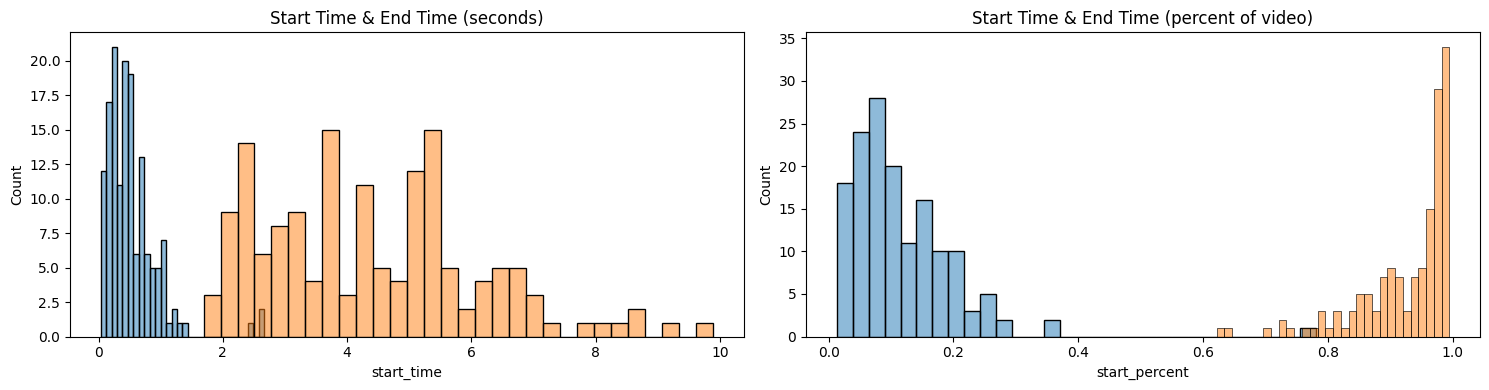

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(analysis_info.start_time, bins=30, ax=ax1, alpha = 0.5)
sns.histplot(analysis_info.end_time, bins=30, ax=ax1, alpha = 0.5)
ax1.set_title('Start Time & End Time (seconds)')
sns.histplot(analysis_info.start_percent, bins=30, ax=ax2, alpha = 0.5) 
sns.histplot(analysis_info.end_percent, bins=30, ax=ax2, alpha = 0.5) 
ax2.set_title('Start Time & End Time (percent of video)')
plt.tight_layout()

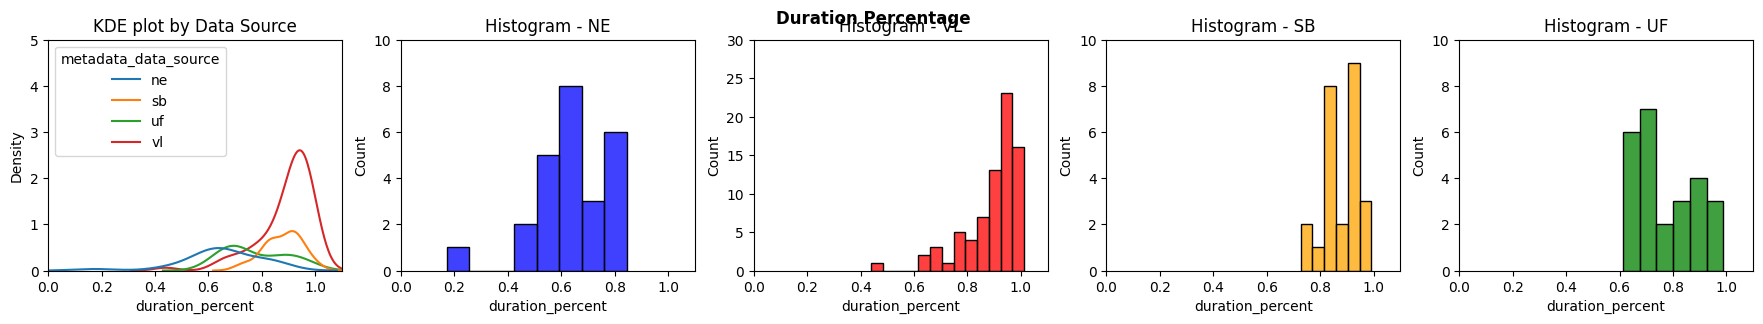

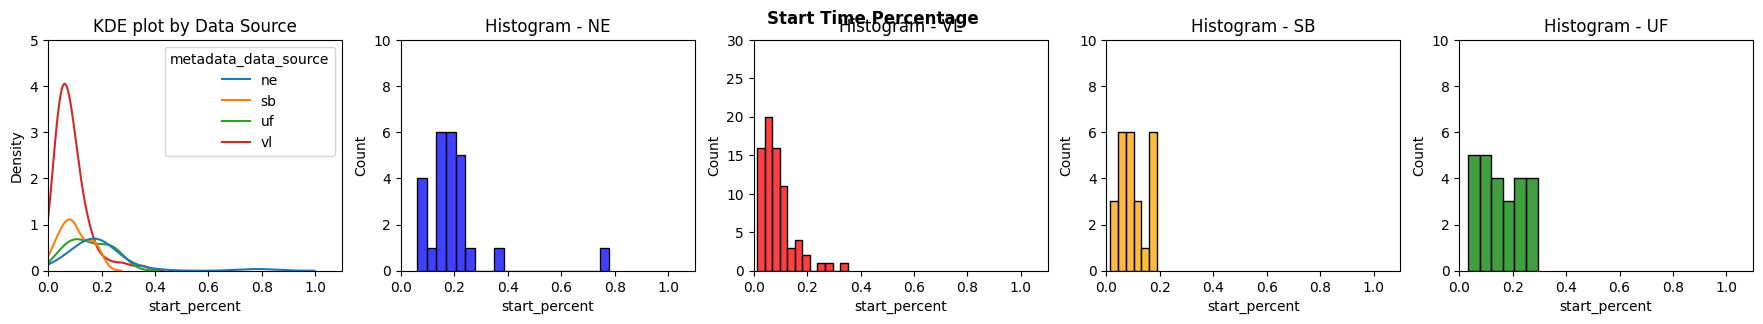

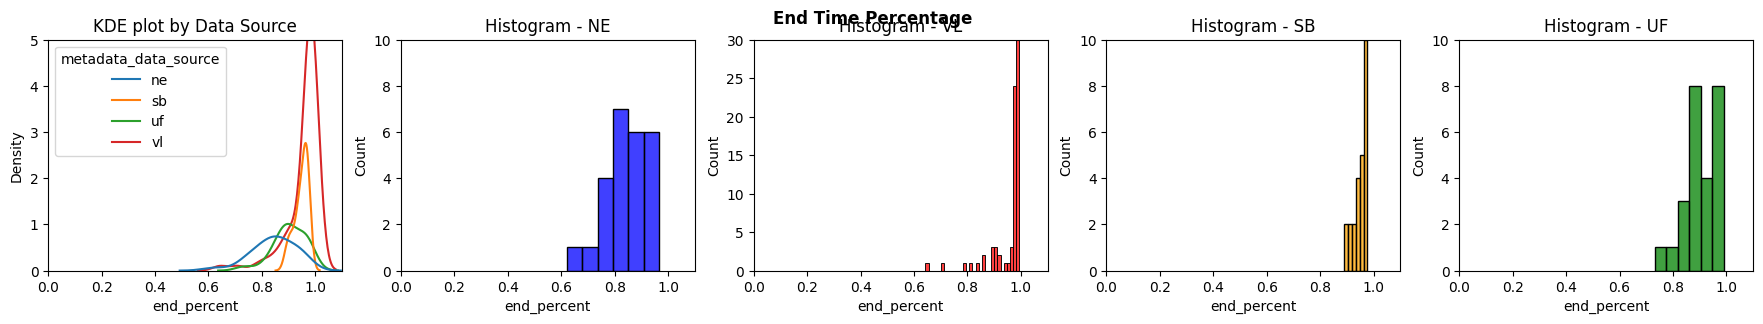

In [266]:
# 5 subplots
fig, axs = plt.subplots(1, 5, figsize=(22, 3));
# kde plot of duration_percent for each data source, histogram of duration_percent for each data source
sns.kdeplot(data = analysis_info, x = 'duration_percent', hue = 'metadata_data_source', ax = axs[0])
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'ne'], x = 'duration_percent', ax = axs[1], color = 'blue',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'vl'], x = 'duration_percent', ax = axs[2], color = 'red',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'sb'], x = 'duration_percent', ax = axs[3], color = 'orange',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'uf'], x = 'duration_percent', ax = axs[4], color = 'green',)
for i, ax in enumerate(axs):
    ax.set_xlim(0, 1.1)
    if i == 0:
        ax.set_ylim(0, 5)
    elif i == 2:
        ax.set_ylim(0, 30)
    else:
        ax.set_ylim(0, 10)
axs[0].set_title('KDE plot by Data Source');
axs[1].set_title('Histogram - NE');
axs[2].set_title('Histogram - VL');
axs[3].set_title('Histogram - SB');
axs[4].set_title('Histogram - UF');
plt.suptitle('Duration Percentage', fontweight = 'bold');

fig, axs = plt.subplots(1, 5, figsize=(22, 3));
# kde plot of duration_percent for each data source, histogram of duration_percent for each data source
sns.kdeplot(data = analysis_info, x = 'start_percent', hue = 'metadata_data_source', ax = axs[0])
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'ne'], x = 'start_percent', ax = axs[1], color = 'blue',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'vl'], x = 'start_percent', ax = axs[2], color = 'red',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'sb'], x = 'start_percent', ax = axs[3], color = 'orange',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'uf'], x = 'start_percent', ax = axs[4], color = 'green',)
for i, ax in enumerate(axs):
    ax.set_xlim(0, 1.1)
    if i == 0:
        ax.set_ylim(0, 5)
    elif i == 2:
        ax.set_ylim(0, 30)
    else:
        ax.set_ylim(0, 10)
axs[0].set_title('KDE plot by Data Source');
axs[1].set_title('Histogram - NE');
axs[2].set_title('Histogram - VL');
axs[3].set_title('Histogram - SB');
axs[4].set_title('Histogram - UF');
plt.suptitle('Start Time Percentage', fontweight = 'bold');


fig, axs = plt.subplots(1, 5, figsize=(22, 3));
# kde plot of duration_percent for each data source, histogram of duration_percent for each data source
sns.kdeplot(data = analysis_info, x = 'end_percent', hue = 'metadata_data_source', ax = axs[0])
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'ne'], x = 'end_percent', ax = axs[1], color = 'blue',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'vl'], x = 'end_percent', ax = axs[2], color = 'red',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'sb'], x = 'end_percent', ax = axs[3], color = 'orange',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'uf'], x = 'end_percent', ax = axs[4], color = 'green',)
for i, ax in enumerate(axs):
    ax.set_xlim(0, 1.1)
    if i == 0:
        ax.set_ylim(0, 5)
    elif i == 2:
        ax.set_ylim(0, 30)
    else:
        ax.set_ylim(0, 10)
axs[0].set_title('KDE plot by Data Source');
axs[1].set_title('Histogram - NE');
axs[2].set_title('Histogram - VL');
axs[3].set_title('Histogram - SB');
axs[4].set_title('Histogram - UF');
plt.suptitle('End Time Percentage', fontweight = 'bold');

<Axes: xlabel='duration_percent'>

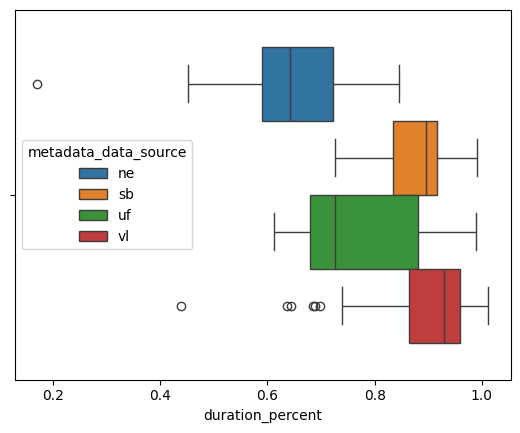

In [267]:
# boxplot
sns.boxplot(data = analysis_info, hue = 'metadata_data_source', x = 'duration_percent')

### Motion Detection Duration

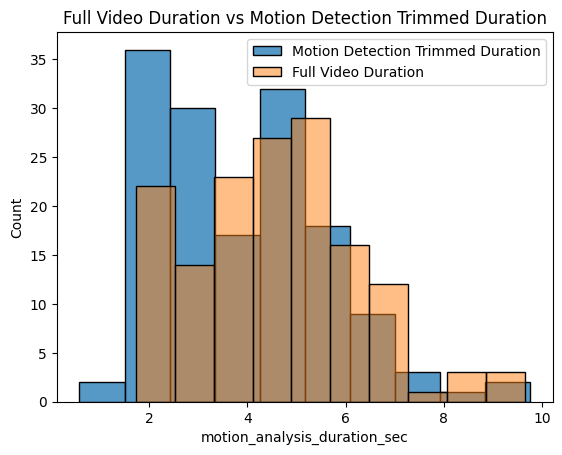

In [268]:
sns.histplot(data=analysis_info, x = 'motion_analysis_duration_sec')
sns.histplot(data=analysis_info, x = 'metadata_duration_sec', alpha = 0.5)
plt.title('Full Video Duration vs Motion Detection Trimmed Duration')
# legend
plt.legend([ 'Motion Detection Trimmed Duration','Full Video Duration',])
plt.show()


In [269]:
analysis_info.sort_values(by = 'motion_analysis_duration_sec', ascending = False)[['metadata_filename', 'metadata_duration_sec', 'motion_analysis_duration_sec']].head(5)

metadata_filename  metadata_duration_sec  motion_analysis_duration_sec
0   ajudar_vl_5.mp4               9.642967                      9.758621
0     sopa_vl_5.mp4               8.908900                      8.862069
0    carne_vl_5.mp4               8.441767                      8.000000
0  sorvete_vl_4.mp4               7.841167                      7.620690
0   banana_uf_3.mp4               8.208200                      7.517241

In [270]:
analysis_info.sort_values(by = 'motion_analysis_duration_sec', ascending = True)[['metadata_filename', 'metadata_duration_sec', 'motion_analysis_duration_sec']].head(5)

metadata_filename  metadata_duration_sec  motion_analysis_duration_sec
0    homem_ne_1.mp4               3.416667                      0.583333
0      pai_sb_2.mp4               1.735067                      1.482759
0   vagina_sb_2.mp4               2.135467                      1.551724
0  crescer_vl_4.mp4               2.419083                      1.559322
0   vagina_ne_1.mp4               2.416667                      1.583333

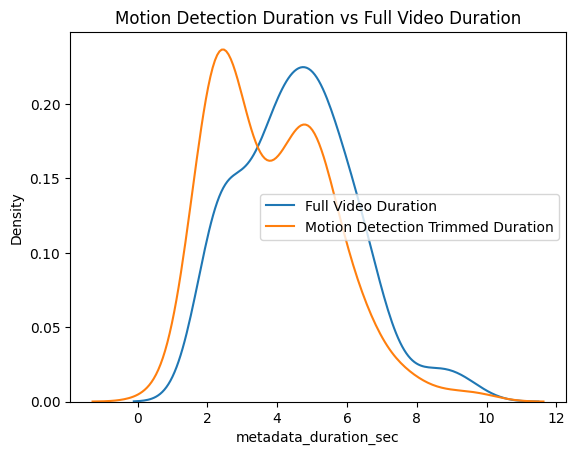

In [271]:
sns.kdeplot(data=analysis_info, x = 'metadata_duration_sec', )
sns.kdeplot(data=analysis_info, x = 'motion_analysis_duration_sec',)
plt.title('Motion Detection Duration vs Full Video Duration')
plt.legend(['Full Video Duration', 'Motion Detection Trimmed Duration'])

Text(0.5, 1.0, 'Full Video Duration - by data source')

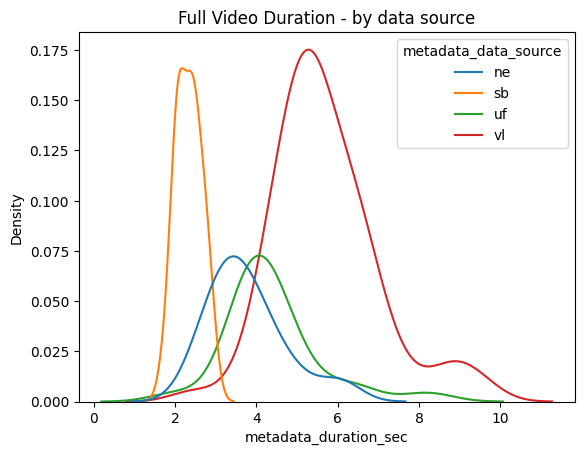

In [272]:
sns.kdeplot(data=analysis_info, x = 'metadata_duration_sec', hue = 'metadata_data_source')
plt.title('Full Video Duration - by data source')

Text(0.5, 1.0, 'Motion Detection Trimmed Duration - by data source')

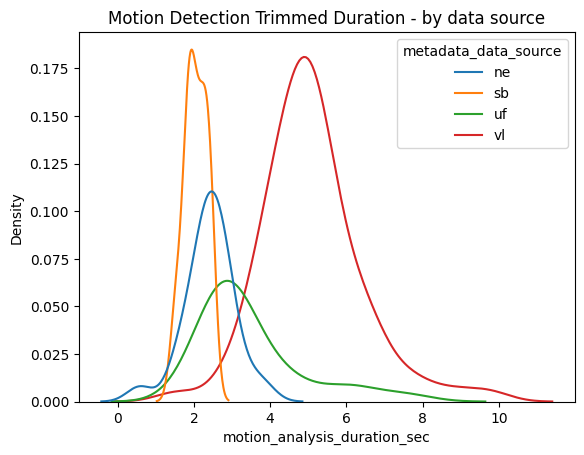

In [273]:
sns.kdeplot(data=analysis_info, x = 'motion_analysis_duration_sec', hue = 'metadata_data_source')
plt.title('Motion Detection Trimmed Duration - by data source')

## Pose Detection Analysis

### Plot Key Reference Points & Max/Min Values

Looking at the key reference points currently used for the horizontal alignment, the vertical alignment, and the scale adjustment

I decided to use the median of the reference points after investigating the distribution of the reference points, you can see that in the next sections

In [16]:
analysis_info.columns


Index(['metadata_filename', 'metadata_fps', 'metadata_width',
       'metadata_height', 'metadata_duration_sec', 'metadata_frame_count',
       'metadata_data_source', 'metadata_label',
       'metadata_motion_detection_version', 'metadata_pose_detection_version',
       ...
       'pose_analysis_landmark_measurements_max_right_x_min',
       'pose_analysis_landmark_measurements_max_top_y_mean',
       'pose_analysis_landmark_measurements_max_top_y_median',
       'pose_analysis_landmark_measurements_max_top_y_max',
       'pose_analysis_landmark_measurements_max_top_y_min', 'start_time',
       'end_time', 'start_percent', 'end_percent', 'duration_percent'],
      dtype='object', length=104)

In [11]:
key_points_analysis_info = analysis_info[[
    'metadata_filename',
    'metadata_data_source',
    'metadata_frame_count',
    'metadata_width',
    'metadata_height',
    'pose_analysis_horizontal_offsets_face_median',
    'pose_analysis_vertical_offsets_face_median',
    'pose_analysis_landmark_measurements_face_width_median',
    'pose_analysis_landmark_measurements_face_height_median',
    'pose_analysis_horizontal_offsets_shoulders_median',
    'pose_analysis_vertical_offsets_shoulders_median',
    'pose_analysis_landmark_measurements_shoulder_width_median',
    'pose_analysis_landmark_measurements_max_left_x_min',
    'pose_analysis_landmark_measurements_max_right_x_max',
    'pose_analysis_landmark_measurements_max_top_y_min'
]].reset_index(drop=True)
key_points_analysis_info['x_range'] = key_points_analysis_info['pose_analysis_landmark_measurements_max_right_x_max'] - key_points_analysis_info['pose_analysis_landmark_measurements_max_left_x_min']
key_points_analysis_info['y_scale'] = key_points_analysis_info['pose_analysis_landmark_measurements_face_height_median'] / (1 - key_points_analysis_info['pose_analysis_vertical_offsets_shoulders_median'])
key_points_analysis_info['max_sign_left_px'] = key_points_analysis_info['metadata_width'] * key_points_analysis_info['pose_analysis_landmark_measurements_max_left_x_min']
key_points_analysis_info['max_sign_right_px'] = key_points_analysis_info['metadata_width'] * key_points_analysis_info['pose_analysis_landmark_measurements_max_right_x_max']
key_points_analysis_info['max_sign_width_px'] = pd.concat([
    key_points_analysis_info['metadata_width']/2 - key_points_analysis_info['max_sign_left_px'],
    key_points_analysis_info['max_sign_right_px'] - key_points_analysis_info['metadata_width']/2
], axis=1).max(axis=1)*2
key_points_analysis_info.head()

metadata_filename metadata_data_source  metadata_frame_count  \
0   ajudar_ne_1.mp4                   ne                    44   
1   ajudar_sb_2.mp4                   sb                    79   
2   ajudar_uf_3.mp4                   uf                   115   
3   ajudar_vl_4.mp4                   vl                   141   
4   ajudar_vl_5.mp4                   vl                   289   

   metadata_width  metadata_height  \
0             240              176   
1            1280              720   
2             480              270   
3            1920             1080   
4            1920             1080   

   pose_analysis_horizontal_offsets_face_median  \
0                                      0.468355   
1                                      0.496027   
2                                      0.491230   
3                                      0.496293   
4                                      0.499771   

   pose_analysis_vertical_offsets_face_median  \
0                                    0.273956   
1                                    0.333085   
2                                    0.378884   
3                                    0.243836   
4                                    0.324946   

   pose_analysis_landmark_measurements_face_width_median  \
0                                           0.145804       
1                                           0.089673       
2                                           0.090457       
3                                           0.099749       
4                                           0.122047       

   pose_analysis_landmark_measurements_face_height_median  \
0                                           0.246427        
1                                           0.186765        
2                                           0.195808        
3                                           0.215714        
4                                           0.239237        

   pose_analysis_horizontal_offsets_shoulders_median  \
0                                           0.486479   
1                                           0.496549   
2                                           0.491493   
3                                           0.507120   
4                                           0.497635   

   pose_analysis_vertical_offsets_shoulders_median  \
0                                         0.541060   
1                                         0.520683   
2                                         0.585544   
3                                         0.454691   
4                                         0.555395   

   pose_analysis_landmark_measurements_shoulder_width_median  \
0                                           0.322242           
1                                           0.194269           
2                                           0.203528           
3                                           0.196968           
4                                           0.236184           

   pose_analysis_landmark_measurements_max_left_x_min  \
0                                           0.182002    
1                                           0.325371    
2                                           0.306210    
3                                           0.298221    
4                                           0.263113    

   pose_analysis_landmark_measurements_max_right_x_max  \
0                                           0.784914     
1                                           0.682229     
2                                           0.672577     
3                                           0.704686     
4                                           0.716663     

   pose_analysis_landmark_measurements_max_top_y_min   x_range   y_scale  \
0                                           0.221278  0.602912  0.536948   
1                                           0.272041  0.356859  0.389649   
2                                           0.332219  0.366366  0.472446   
3  

In [160]:
# Create a table of min/max values for each key point
data = []
for col in key_points_analysis_info.columns[5:]:
    max_idx = key_points_analysis_info[col].idxmax()
    min_idx = key_points_analysis_info[col].idxmin()
    max_row = key_points_analysis_info.iloc[max_idx]
    min_row = key_points_analysis_info.iloc[min_idx]
    
    data.append({
        'Metric': col,
        'Max_Value': f"{max_row[col]:.3f}",
        'Max_File': max_row['metadata_filename'],
        'Min_Value': f"{min_row[col]:.3f}", 
        'Min_File': min_row['metadata_filename']
    })

min_max_df = pd.DataFrame(data)
display(min_max_df.style.set_properties(**{'text-align': 'left'})
        .set_table_styles([dict(selector='th', props=[('text-align', 'left')])]))


### Sign X max & min values

<Axes: xlabel='pose_analysis_landmark_measurements_max_left_x_min', ylabel='Count'>

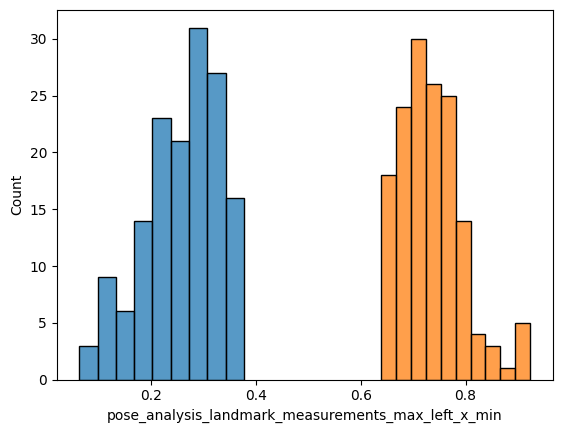

In [12]:
sns.histplot(analysis_info['pose_analysis_landmark_measurements_max_left_x_min'])
sns.histplot(analysis_info['pose_analysis_landmark_measurements_max_right_x_max'])

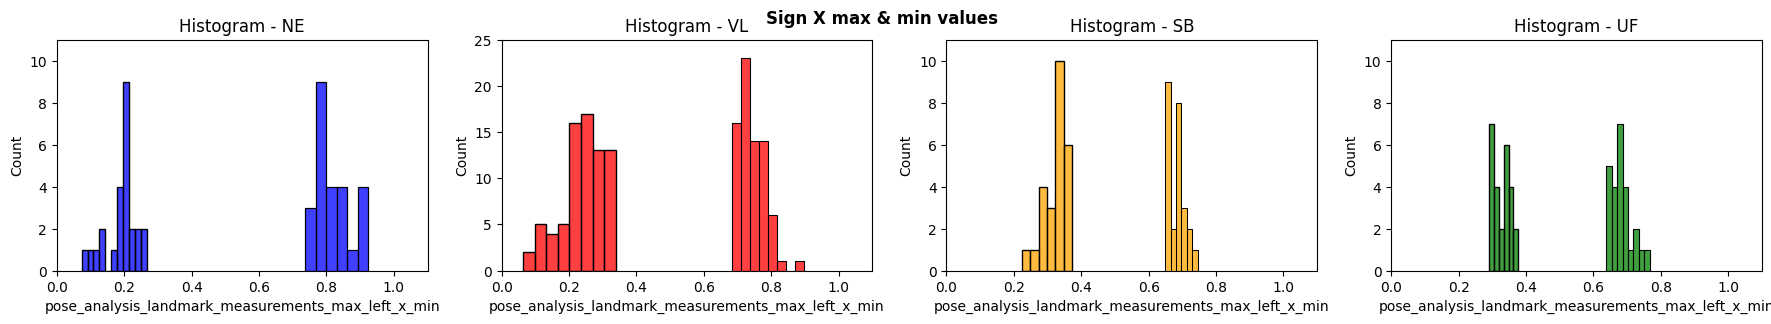

In [13]:
# 5 subplots
fig, axs = plt.subplots(1, 4, figsize=(22, 3));
# kde plot of duration_percent for each data source, histogram of duration_percent for each data source
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'ne'], x = 'pose_analysis_landmark_measurements_max_left_x_min', ax = axs[0], color = 'blue',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'vl'], x = 'pose_analysis_landmark_measurements_max_left_x_min', ax = axs[1], color = 'red',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'sb'], x = 'pose_analysis_landmark_measurements_max_left_x_min', ax = axs[2], color = 'orange',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'uf'], x = 'pose_analysis_landmark_measurements_max_left_x_min', ax = axs[3], color = 'green',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'ne'], x = 'pose_analysis_landmark_measurements_max_right_x_max', ax = axs[0], color = 'blue',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'vl'], x = 'pose_analysis_landmark_measurements_max_right_x_max', ax = axs[1], color = 'red',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'sb'], x = 'pose_analysis_landmark_measurements_max_right_x_max', ax = axs[2], color = 'orange',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'uf'], x = 'pose_analysis_landmark_measurements_max_right_x_max', ax = axs[3], color = 'green',)
for i, ax in enumerate(axs):
    ax.set_xlim(0, 1.1)
    if i == 1:
        ax.set_ylim(0, 25)
    else:
        ax.set_ylim(0, 11)
axs[0].set_title('Histogram - NE');
axs[1].set_title('Histogram - VL');
axs[2].set_title('Histogram - SB');
axs[3].set_title('Histogram - UF');
plt.suptitle('Sign X max & min values', fontweight = 'bold');


<Axes: xlabel='pose_analysis_landmark_measurements_max_left_x_min', ylabel='Density'>

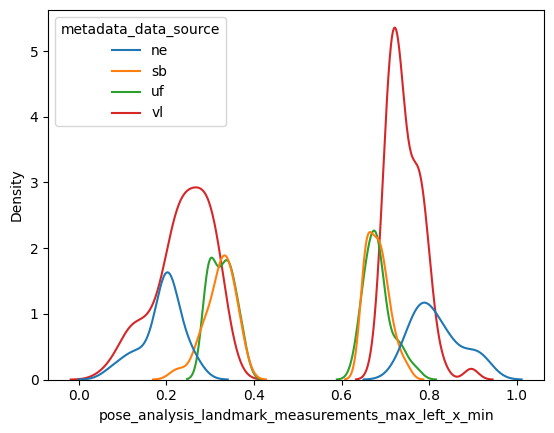

In [14]:
sns.kdeplot(data = analysis_info, x = 'pose_analysis_landmark_measurements_max_left_x_min', hue = 'metadata_data_source')
sns.kdeplot(data = analysis_info, x = 'pose_analysis_landmark_measurements_max_right_x_max', hue = 'metadata_data_source')

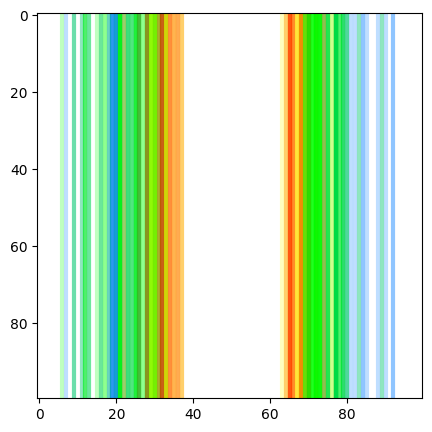

In [15]:
# plot a white square
plt.figure(figsize=(5, 5))
plt.imshow(np.ones((100, 100, 3), dtype=np.uint8) * 255)

color_dict = {
    'ne': (0, 125/255, 255/255), # blue
    'vl': (0, 255/255, 0), # green
    'sb': (255/255, 0, 0), # red
    'uf': (255/255, 255/255, 0), # yellow
}
for i, row in analysis_info.iterrows():
    left_x = int(row['pose_analysis_landmark_measurements_max_left_x_min'] * 100)
    right_x = int(row['pose_analysis_landmark_measurements_max_right_x_max'] * 100)
    top_y = int(row['pose_analysis_landmark_measurements_max_top_y_min'] * 100)
    # plt.axhline(y=top_y, xmin=left_x/100, xmax=right_x/100, color=color_dict[row['metadata_data_source']], linewidth=2, alpha=0.25)
    plt.axvline(x=left_x, ymin=0, ymax=1, color=color_dict[row['metadata_data_source']], linewidth=3, alpha=0.25)
    plt.axvline(x=right_x, ymin=0, ymax=1, color=color_dict[row['metadata_data_source']], linewidth=3, alpha=0.25)
plt.show()


#### Can we crop videos to square without losing any hand information?

In [161]:
max_sign_pos_info = key_points_analysis_info[[
    'metadata_data_source', 
    'metadata_width', 
    'metadata_height', 
    'pose_analysis_landmark_measurements_max_left_x_min',
    'pose_analysis_landmark_measurements_max_right_x_max',
    'max_sign_left_px', 
    'max_sign_right_px', 
    'max_sign_width_px'
    ]].groupby(['metadata_data_source', 'metadata_height']).max()
min_sign_pos_info = key_points_analysis_info[[
    'metadata_data_source', 
    'metadata_height', 
    'max_sign_left_px',
    ]].groupby(['metadata_data_source', 'metadata_height']).min()

max_sign_pos_info['metadata_height'] = max_sign_pos_info.index.get_level_values(1).values
max_sign_pos_info['min_sign_left_px'] = min_sign_pos_info['max_sign_left_px'] 

max_sign_pos_info['x_range'] = max_sign_pos_info['max_sign_right_px'] - max_sign_pos_info['min_sign_left_px']
max_sign_pos_info['x_range_>_height'] = max_sign_pos_info['x_range'] > max_sign_pos_info['metadata_height']
max_sign_pos_info['max_sign_width_>_height'] = max_sign_pos_info['max_sign_width_px'] > max_sign_pos_info['metadata_height']

max_sign_pos_info['aspect_ratio'] = max_sign_pos_info['metadata_width'] / max_sign_pos_info['metadata_height']
max_sign_pos_info['min_aspect_ratio'] = max_sign_pos_info['max_sign_width_px'] / max_sign_pos_info['metadata_height']
max_sign_pos_info['centered_max_aspect_ratio'] = max_sign_pos_info['x_range'] / max_sign_pos_info['metadata_height']

min_aspect_ratio = 240/176
max_sign_pos_info['new_width'] = (max_sign_pos_info['metadata_height'] * min_aspect_ratio).round(0).astype(int)
max_sign_pos_info['total_trimmed_x'] = max_sign_pos_info['metadata_width'] - max_sign_pos_info['new_width']
max_sign_pos_info['left_trim_x'] = max_sign_pos_info['total_trimmed_x'] / 2
max_sign_pos_info['right_trim_x'] = max_sign_pos_info['metadata_width'] - (max_sign_pos_info['total_trimmed_x'] / 2)
max_sign_pos_info['left_info_lost'] = max_sign_pos_info['left_trim_x'] > max_sign_pos_info['min_sign_left_px']
max_sign_pos_info['right_info_lost'] = max_sign_pos_info['right_trim_x'] < max_sign_pos_info['max_sign_right_px']
max_sign_pos_info['centered_info_lost'] = max_sign_pos_info['new_width'] < max_sign_pos_info['max_sign_width_px']


max_sign_pos_info

metadata_width  \
metadata_data_source metadata_height                   
ne                   176                         240   
sb                   720                        1280   
                     1080                       1920   
uf                   270                         480   
                     1080                       1920   
vl                   720                        1280   
                     1080                       1920   

                                      pose_analysis_landmark_measurements_max_left_x_min  \
metadata_data_source metadata_height                                                       
ne                   176                                                       0.266347    
sb                   720                                                       0.372210    
                     1080                                                      0.334232    
uf                   270                                                       0.345508    
                     1080                                                      0.376931    
vl                   720                                                       0.284477    
                     1080                                                      0.338439    

                                      pose_analysis_landmark_measurements_max_right_x_max  \
metadata_data_source metadata_height                                                        
ne                   176                                                       0.923652     
sb                   720                                                       0.746250     
                     1080                                                      0.673011     
uf                   270                                                       0.766600     
                     1080                                                      0.680516     
vl                   720                                                       0.798667     
                     1080                                                      0.896004     

                                      max_sign_left_px  max_sign_right_px  \
metadata_data_source metadata_height                                        
ne                   176                     63.923314         221.676478   
sb                   720                    476.429062         955.199966   
                     1080                   641.724987        1292.181129   
uf                   270                    165.843730         367.968235   
                     1080                   723.708000        1306.591530   
vl                   720                    364.130707        1022.293320   
                     1080                   649.802914        1720.327492   

                                      max_sign_width_px  metadata_height  \
metadata_data_source metadata_height                                       
ne                   176                     204.693496              176   
sb                   720                     704.959297              720   
                     1080                    743.880043             1080   
uf                   270                     255.936470              270   
                     1080                    693.183060             1080   
vl                   720                     764.586639              720   
                     1080                   1676.400948             1080   

                                      min_sign_left_px      x_range  \
metadata_data_source metadata_height                                  
ne                   176                     17.653252   204.023226   
sb                   720                    287.520351   667.679615   
                     1080                   588.059978   704.121151   
uf                   270                    139.372702   228.595533   
                     1080                   645.861454   660.

In [165]:
key_points_analysis_info.loc[key_points_analysis_info['pose_analysis_landmark_measurements_max_right_x_max'] > 0.896]

metadata_filename metadata_data_source  metadata_frame_count  \
12   aniversário_ne_1.mp4                   ne                    74   
84       crescer_ne_1.mp4                   ne                    46   
114        jovem_ne_1.mp4                   ne                    33   
119        jovem_vl_6.mp4                   vl                   322   

     metadata_width  metadata_height  \
12              240              176   
84              240              176   
114             240              176   
119            1920             1080   

     pose_analysis_horizontal_offsets_face_median  \
12                                       0.499998   
84                                       0.473161   
114                                      0.461147   
119                                      0.493927   

     pose_analysis_vertical_offsets_face_median  \
12                                     0.267671   
84                                     0.308732   
114                                    0.320180   
119                                    0.258375   

     pose_analysis_landmark_measurements_face_width_median  \
12                                            0.145853       
84                                            0.156493       
114                                           0.149823       
119                                           0.133031       

     pose_analysis_landmark_measurements_face_height_median  \
12                                            0.247575        
84                                            0.264946        
114                                           0.258764        
119                                           0.295482        

     pose_analysis_horizontal_offsets_shoulders_median  ...  \
12                                            0.521108  ...   
84                                            0.491484  ...   
114                                           0.480585  ...   
119                                           0.492595  ...   

     pose_analysis_landmark_measurements_shoulder_width_median  \
12                                            0.326794           
84                                            0.350225           
114                                           0.324312           
119                                           0.283882           

     pose_analysis_landmark_measurements_max_left_x_min  \
12                                            0.129540    
84                                            0.213947    
114                                           0.207625    
119                                           0.226404    

     pose_analysis_landmark_measurements_max_right_x_max  \
12                                            0.909349     
84                                            0.923652     
114                                           0.921962     
119                                           0.896004     

     pose_analysis_landmark_measurements_max_top_y_min   x_range   y_scale  \
12                                            0.223370  0.779809  0.547330   
84                                            0.156341  0.709705  0.657917   
114                                           0.268468  0.714336  0.636999   
119                                           0.208547  0.669600  0.667927   

     max_sign_left_px  max_sign_right_px  max_sign_width_px  \
12          31.089599         218.243737         196.487474   
84          51.347312         221.676478         203.352957   
114         49.830090         221.270828         202.541656   
119        434.696388        1720.327492        1520.654984   

     source_width_height_str  
12                  ne240176  
84                  ne240176  
114                 ne240176  
119               vl19201080  

[4 rows x 21 columns]

In [50]:
max_sign_pos_info.index.get_level_values(1).values
# get metadata_height from multiindex

array([ 176,  720, 1080,  270, 1080,  720, 1080])

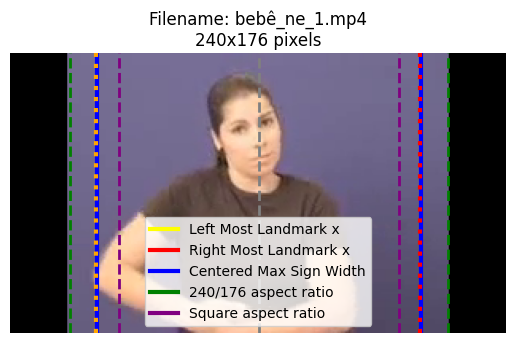

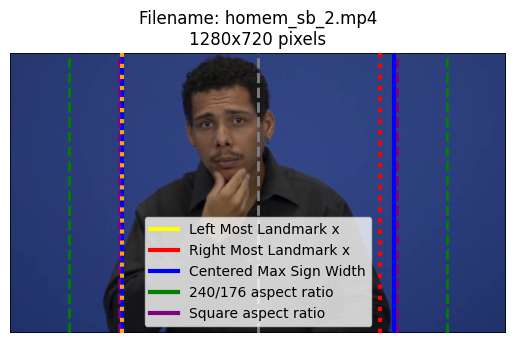

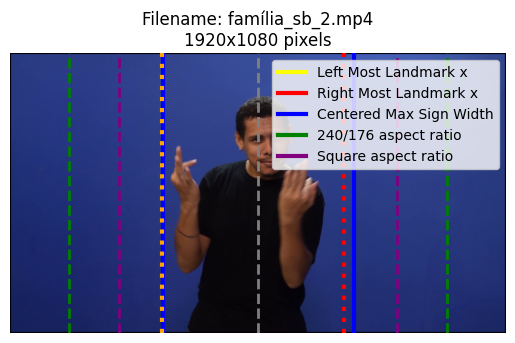

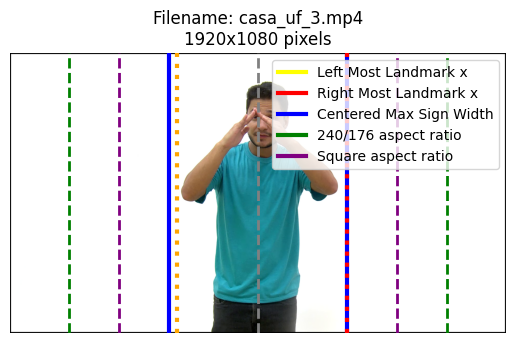

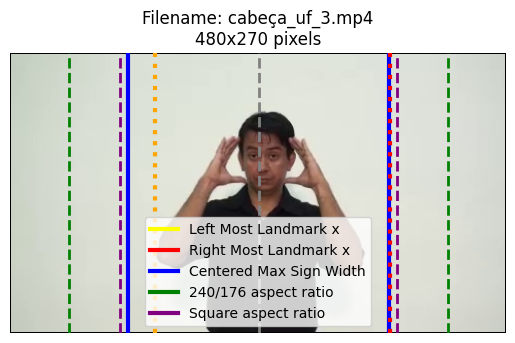

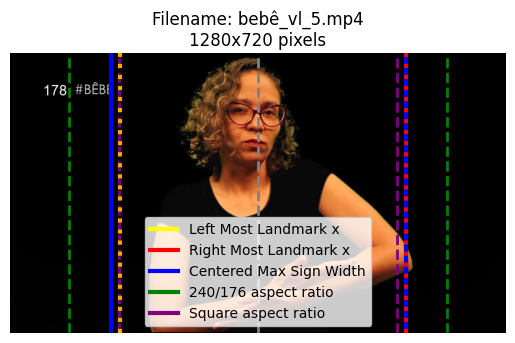

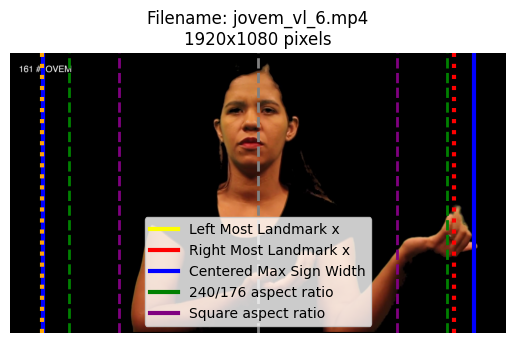

In [162]:
key_points_analysis_info['source_width_height_str'] = key_points_analysis_info['metadata_data_source'] + key_points_analysis_info['metadata_width'].astype(str) + key_points_analysis_info['metadata_height'].astype(str)
source_aspect_ratio_combos = sorted(key_points_analysis_info['source_width_height_str'].unique())
for i, combo in enumerate(source_aspect_ratio_combos):
    # max left, max right, centered max range, aspect ratio lines
    example_row = key_points_analysis_info[key_points_analysis_info['source_width_height_str'] == combo].sort_values(by = 'x_range', ascending = False).iloc[0]
    filename, source, width, height, frame_count = example_row[['metadata_filename', 'metadata_data_source', 'metadata_width', 'metadata_height', 'metadata_frame_count']]
    df_slice = key_points_analysis_info[
        (key_points_analysis_info['metadata_data_source'] == source) & 
        (key_points_analysis_info['metadata_width'] == width) & 
        (key_points_analysis_info['metadata_height'] == height)
    ]
    min_left_x = df_slice['pose_analysis_landmark_measurements_max_left_x_min'].min()
    max_right_x = df_slice['pose_analysis_landmark_measurements_max_right_x_max'].max()
    max_sign_width = df_slice['max_sign_width_px'].max()
    x_range = max_right_x - min_left_x

    min_aspect_ratio = 240/176
    new_width = height * min_aspect_ratio
    total_trimmed_x = width - new_width
    left_trim_x = total_trimmed_x / 2
    right_trim_x = width - (total_trimmed_x / 2)
    center_frame = frame_count // 2

    max_aspect_ratio = 1920/1080
    full_width = max_aspect_ratio * height
    missing_width = full_width - width
    side_bar_width = int(missing_width//2)

    frame = viz.get_frame(center_frame, path_to_root + '/data/raw/combined/videos/' + filename)
    frame = cv2.copyMakeBorder(frame, 0, 0, side_bar_width, side_bar_width, cv2.BORDER_CONSTANT, value=(0,0,0))
    black_border = width//480
    frame = cv2.copyMakeBorder(frame, black_border, black_border, black_border, black_border, cv2.BORDER_CONSTANT, value=(0,0,0))
    left_add = side_bar_width + black_border
    plt.imshow(frame)

    center = frame.shape[1]//2
    plt.axvline(x=center, color='gray', linewidth=2, linestyle='--')
    half_max_sign_width = (max_sign_width)//2
    plt.axvline(x=center-half_max_sign_width, color='blue', linewidth=3)
    plt.axvline(x=center+half_max_sign_width, color='blue', linewidth=3)
    half_new_width = (new_width)//2
    plt.axvline(x=center-half_new_width, color='green', linewidth=2, linestyle='--')
    plt.axvline(x=center+half_new_width, color='green', linewidth=2, linestyle='--')
    half_height = height//2
    plt.axvline(x=center-half_height, color='purple', linewidth=2, linestyle='--')
    plt.axvline(x=center+half_height, color='purple', linewidth=2, linestyle='--')
    plt.axvline(x=(min_left_x*width)+left_add, color='orange', linewidth=3, linestyle=':')
    plt.axvline(x=(max_right_x*width)+left_add, color='red', linewidth=3, linestyle=':')

    plt.title(f"Filename: {filename}\n{width}x{height} pixels")
    legend_elements = [
        plt.Line2D([0], [0], color='yellow', lw=3),
        plt.Line2D([0], [0], color='red', lw=3),
        plt.Line2D([0], [0], color='blue', lw=3),
        plt.Line2D([0], [0], color='green', lw=3),
        plt.Line2D([0], [0], color='purple', lw=3)
    ]
    plt.legend(legend_elements, ['Left Most Landmark x', 'Right Most Landmark x', 'Centered Max Sign Width', '240/176 aspect ratio', 'Square aspect ratio'])
    plt.axis('off')
    plt.show()

### Looking at Max & Min values for a bunch of measurements

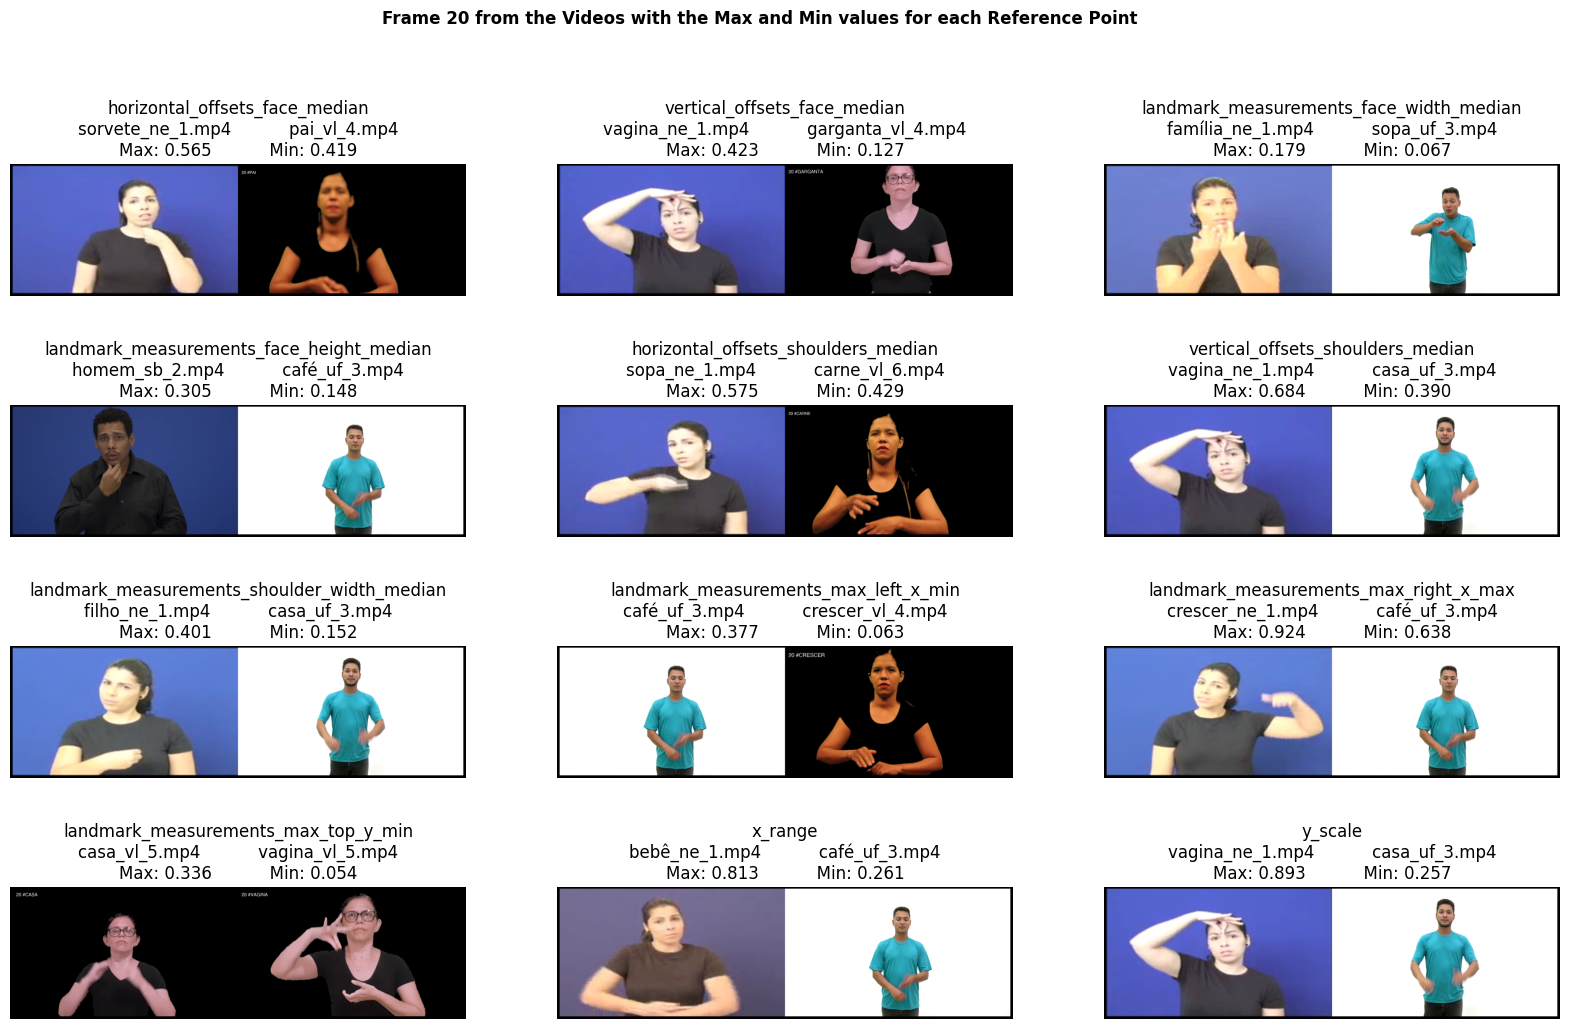

In [34]:
frame_index = 20
# 6 subplots
fig, axs = plt.subplots(4, 3, figsize=(20, 12))
video_path = path_to_root + '/data/raw/combined/videos/'

for ax, (i, row) in zip(axs.flatten(), min_max_df.iterrows()):
    max_frame = viz.get_frame(frame_index, video_path + row['Max_File'])
    min_frame = viz.get_frame(frame_index, video_path + row['Min_File'])
    # resize and hstack
    height = 480
    max_frame = cv2.resize(max_frame, (int(height * 16 / 9), height))
    min_frame = cv2.resize(min_frame, (int(height * 16 / 9), height))
    combined_frame = np.hstack((max_frame, min_frame))
    combined_frame = cv2.copyMakeBorder(combined_frame, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=(0,0,0))
    ax.imshow(combined_frame)
    ax.set_title(f"{row['Metric'].replace('pose_analysis_', '')}\n{row['Max_File']}           {row['Min_File']}\nMax: {row['Max_Value']}           Min: {row['Min_Value']}")
    ax.axis('off')

plt.suptitle(f'Frame {frame_index} from the Videos with the Max and Min values for each Reference Point', fontweight = 'bold')
plt.show()

/tmp/ipykernel_1712/2432040153.py:43: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  top_left = (int(max_key_points['min_left_x']), int(max_key_points['min_top_y']))
/tmp/ipykernel_1712/2432040153.py:44: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  bottom_right = (int(max_key_points['max_right_x']), height)
/tmp/ipykernel_1712/2432040153.py:49: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  top_left = (int(min_key_points['min_left_x']), int(min_key_points['min_top_y']))
/tmp/ipykernel_1712/2432040153.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  bottom_right = (int(min_key_points['max_right_x']), height)


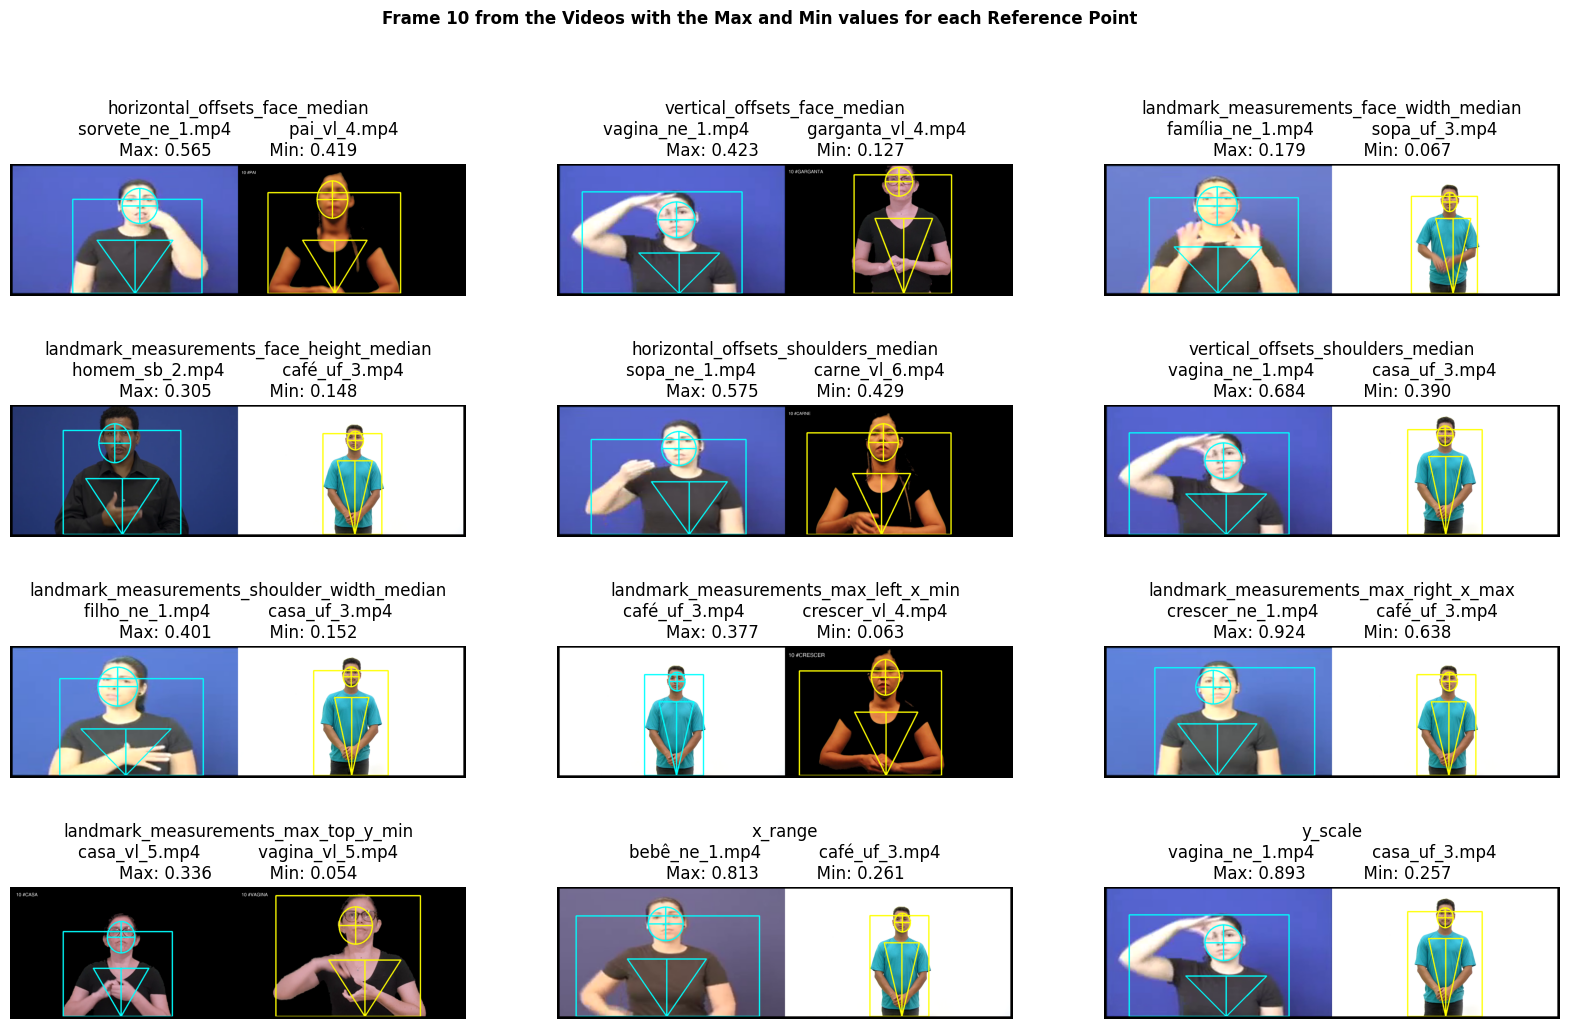

In [33]:
frame_index = 10
# 6 subplots
fig, axs = plt.subplots(4, 3, figsize=(20, 12))
video_path = path_to_root + '/data/raw/combined/videos/'

for ax, (i, row) in zip(axs.flatten(), min_max_df.iterrows()):
    max_frame = viz.get_frame(frame_index, video_path + row['Max_File'])
    min_frame = viz.get_frame(frame_index, video_path + row['Min_File'])
    # resize and hstack
    height = 480
    max_frame = cv2.resize(max_frame, (int(height * 16 / 9), height))
    min_frame = cv2.resize(min_frame, (int(height * 16 / 9), height))
    max_frame_width = max_frame.shape[1]
    min_frame_width = min_frame.shape[1]

    max_key_points = {
    'face_horizontal_offset': analysis_info[analysis_info['metadata_filename'] == row['Max_File']]['pose_analysis_horizontal_offsets_face_median'],
    'face_vertical_offset': analysis_info[analysis_info['metadata_filename'] == row['Max_File']]['pose_analysis_vertical_offsets_face_median'],
    'face_width': analysis_info[analysis_info['metadata_filename'] == row['Max_File']]['pose_analysis_landmark_measurements_face_width_median'],
    'face_height': analysis_info[analysis_info['metadata_filename'] == row['Max_File']]['pose_analysis_landmark_measurements_face_height_median'],
    'shoulders_horizontal_offset': analysis_info[analysis_info['metadata_filename'] == row['Max_File']]['pose_analysis_horizontal_offsets_shoulders_median'],
    'shoulders_vertical_offset': analysis_info[analysis_info['metadata_filename'] == row['Max_File']]['pose_analysis_vertical_offsets_shoulders_median'],
    'shoulders_width': analysis_info[analysis_info['metadata_filename'] == row['Max_File']]['pose_analysis_landmark_measurements_shoulder_width_median'],
    'min_left_x': analysis_info[analysis_info['metadata_filename'] == row['Max_File']]['pose_analysis_landmark_measurements_max_left_x_min'] * max_frame_width,
    'max_right_x': analysis_info[analysis_info['metadata_filename'] == row['Max_File']]['pose_analysis_landmark_measurements_max_right_x_max'] * max_frame_width,
    'min_top_y': analysis_info[analysis_info['metadata_filename'] == row['Max_File']]['pose_analysis_landmark_measurements_max_top_y_min'] * height,
    }
    min_key_points = {
    'face_horizontal_offset': analysis_info[analysis_info['metadata_filename'] == row['Min_File']]['pose_analysis_horizontal_offsets_face_median'],
    'face_vertical_offset': analysis_info[analysis_info['metadata_filename'] == row['Min_File']]['pose_analysis_vertical_offsets_face_median'],
    'face_width': analysis_info[analysis_info['metadata_filename'] == row['Min_File']]['pose_analysis_landmark_measurements_face_width_median'],
    'face_height': analysis_info[analysis_info['metadata_filename'] == row['Min_File']]['pose_analysis_landmark_measurements_face_height_median'],
    'shoulders_horizontal_offset': analysis_info[analysis_info['metadata_filename'] == row['Min_File']]['pose_analysis_horizontal_offsets_shoulders_median'],
    'shoulders_vertical_offset': analysis_info[analysis_info['metadata_filename'] == row['Min_File']]['pose_analysis_vertical_offsets_shoulders_median'],
    'shoulders_width': analysis_info[analysis_info['metadata_filename'] == row['Min_File']]['pose_analysis_landmark_measurements_shoulder_width_median'],
    'min_left_x': analysis_info[analysis_info['metadata_filename'] == row['Min_File']]['pose_analysis_landmark_measurements_max_left_x_min'] * min_frame_width,
    'max_right_x': analysis_info[analysis_info['metadata_filename'] == row['Min_File']]['pose_analysis_landmark_measurements_max_right_x_max'] * min_frame_width,
    'min_top_y': analysis_info[analysis_info['metadata_filename'] == row['Min_File']]['pose_analysis_landmark_measurements_max_top_y_min'] * height,
    }

    max_frame = viz.plot_key_landmarks(max_key_points, max_frame, (0, 255, 255), triangle=True, line_width=3)
    # draw rectange
    top_left = (int(max_key_points['min_left_x']), int(max_key_points['min_top_y']))
    bottom_right = (int(max_key_points['max_right_x']), height)
    max_frame = cv2.rectangle(max_frame, top_left, bottom_right, (0, 255, 255), 3)

    min_frame = viz.plot_key_landmarks(min_key_points, min_frame, (255, 255, 0), triangle=True, line_width=3)
    # draw rectange
    top_left = (int(min_key_points['min_left_x']), int(min_key_points['min_top_y']))
    bottom_right = (int(min_key_points['max_right_x']), height)
    min_frame = cv2.rectangle(min_frame, top_left, bottom_right, (255, 255, 0), 3)

    combined_frame = np.hstack((max_frame, min_frame))
    combined_frame = cv2.copyMakeBorder(combined_frame, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=(0,0,0))
    ax.imshow(combined_frame)
    ax.set_title(f"{row['Metric'].replace('pose_analysis_', '')}\n{row['Max_File']}           {row['Min_File']}\nMax: {row['Max_Value']}           Min: {row['Min_Value']}")
    ax.axis('off')

plt.suptitle(f'Frame {frame_index} from the Videos with the Max and Min values for each Reference Point', fontweight = 'bold')
plt.show()

### Looking at the overall reference points

In [12]:
color_dict = {
    'ne': (0, 125, 255), # blue
    'vl': (0, 255, 0), # green
    'sb': (255, 0, 0), # red
    'uf': (255, 255, 0), # yellow
}

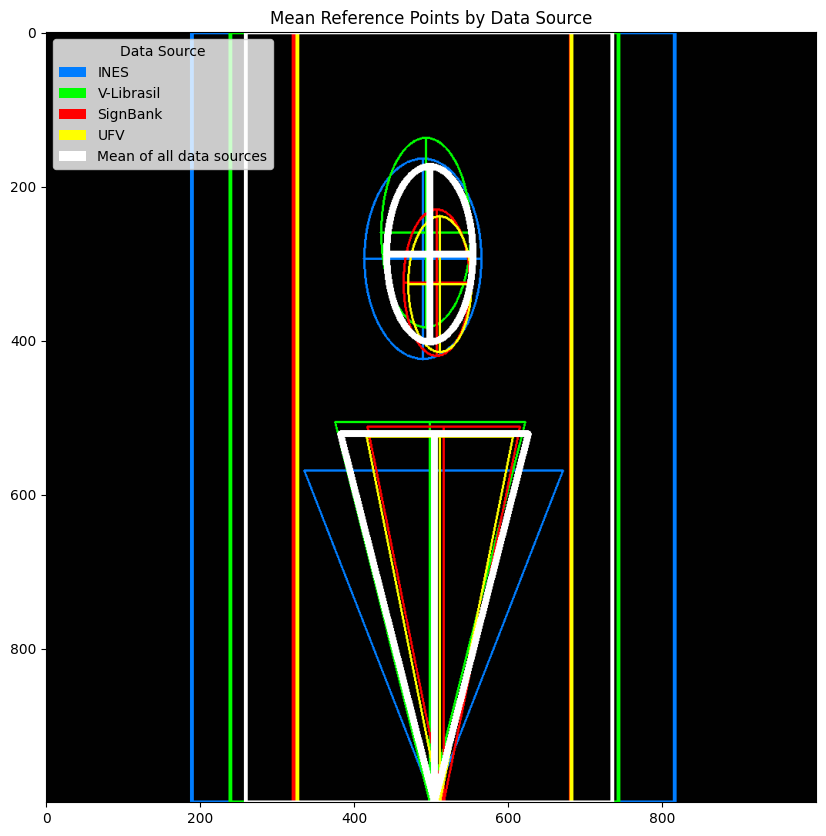

In [13]:
# get the mean of the reference points for each data source
plot_sign_lines = True
ref_points_by_data_source = {}
for data_source in ['ne', 'vl', 'sb', 'uf']:
    ref_points_by_data_source[data_source] = {
        'face_horizontal_offset': analysis_info[
            analysis_info['metadata_data_source'] == data_source
        ]['pose_analysis_horizontal_offsets_face_median'].mean(),
        'face_vertical_offset': analysis_info[
            analysis_info['metadata_data_source'] == data_source
        ]['pose_analysis_vertical_offsets_face_median'].mean(),
        'face_width': analysis_info[
            analysis_info['metadata_data_source'] == data_source
        ]['pose_analysis_landmark_measurements_face_width_median'].mean(),
        'face_height': analysis_info[
            analysis_info['metadata_data_source'] == data_source
        ]['pose_analysis_landmark_measurements_face_height_median'].mean(),
        'shoulders_horizontal_offset': analysis_info[
            analysis_info['metadata_data_source'] == data_source
        ]['pose_analysis_horizontal_offsets_shoulders_median'].mean(),
        'shoulders_vertical_offset': analysis_info[
            analysis_info['metadata_data_source'] == data_source
        ]['pose_analysis_vertical_offsets_shoulders_median'].mean(),
        'shoulders_width': analysis_info[
            analysis_info['metadata_data_source'] == data_source
        ]['pose_analysis_landmark_measurements_shoulder_width_median'].mean(),
        'sign_left_x': analysis_info[
            analysis_info['metadata_data_source'] == data_source
        ]['pose_analysis_landmark_measurements_max_left_x_min'].mean(),
        'sign_right_x': analysis_info[
            analysis_info['metadata_data_source'] == data_source
        ]['pose_analysis_landmark_measurements_max_right_x_max'].mean(),
    }
# get the mean of the reference points for all data sources
mean_ref_points = {
'face_horizontal_offset': analysis_info['pose_analysis_horizontal_offsets_face_median'].mean(),
'face_vertical_offset': analysis_info['pose_analysis_vertical_offsets_face_median'].mean(),
'face_width': analysis_info['pose_analysis_landmark_measurements_face_width_median'].mean(),
'face_height': analysis_info['pose_analysis_landmark_measurements_face_height_median'].mean(),
'shoulders_horizontal_offset': analysis_info['pose_analysis_horizontal_offsets_shoulders_median'].mean(),
'shoulders_vertical_offset': analysis_info['pose_analysis_vertical_offsets_shoulders_median'].mean(),
'shoulders_width': analysis_info['pose_analysis_landmark_measurements_shoulder_width_median'].mean(),
'sign_left_x': analysis_info['pose_analysis_landmark_measurements_max_left_x_min'].mean(),
'sign_right_x': analysis_info['pose_analysis_landmark_measurements_max_right_x_max'].mean(),
}
# plot the reference points for each data source
canvas_dims = 1000
canvas_ref = np.ones((canvas_dims, canvas_dims, 3), dtype=np.uint8)
for data_source in ref_points_by_data_source.keys():
    canvas_ref = viz.plot_key_landmarks(
        ref_points_by_data_source[data_source], 
        canvas_ref, 
        color_dict[data_source], 
        triangle=True
    )
    if plot_sign_lines:
        canvas_ref = cv2.rectangle(canvas_ref, (int(ref_points_by_data_source[data_source]['sign_left_x'] * canvas_dims), 0), (int(ref_points_by_data_source[data_source]['sign_right_x'] * canvas_dims), canvas_dims), color_dict[data_source], 3)
# plot the mean of the reference points
canvas_ref = viz.plot_key_landmarks(mean_ref_points, canvas_ref, (255, 255, 255), triangle=True, line_width=7)
if plot_sign_lines:
    canvas_ref = cv2.rectangle(canvas_ref, (int(mean_ref_points['sign_left_x'] * canvas_dims), 0), (int(mean_ref_points['sign_right_x'] * canvas_dims), canvas_dims), (255, 255, 255), 3)
plt.figure(figsize=(10, 10))
plt.imshow(canvas_ref)
plt.title('Mean Reference Points by Data Source')

# Create custom legend patches
legend_patches = [
    plt.Rectangle((0,0), 1, 1, fc=tuple(x/255 for x in color_dict['ne'])),  # blue
    plt.Rectangle((0,0), 1, 1, fc=tuple(x/255 for x in color_dict['vl'])),  # green  
    plt.Rectangle((0,0), 1, 1, fc=tuple(x/255 for x in color_dict['sb'])),  # red
    plt.Rectangle((0,0), 1, 1, fc=tuple(x/255 for x in color_dict['uf'])),  # yellow
    plt.Rectangle((0,0), 1, 1, fc=(1, 1, 1))  # white for mean
]
plt.gca().legend(legend_patches, ['INES', 'V-Librasil', 'SignBank', 'UFV', 'Mean of all data sources'], 
                title='Data Source', loc='upper left')
plt.show()


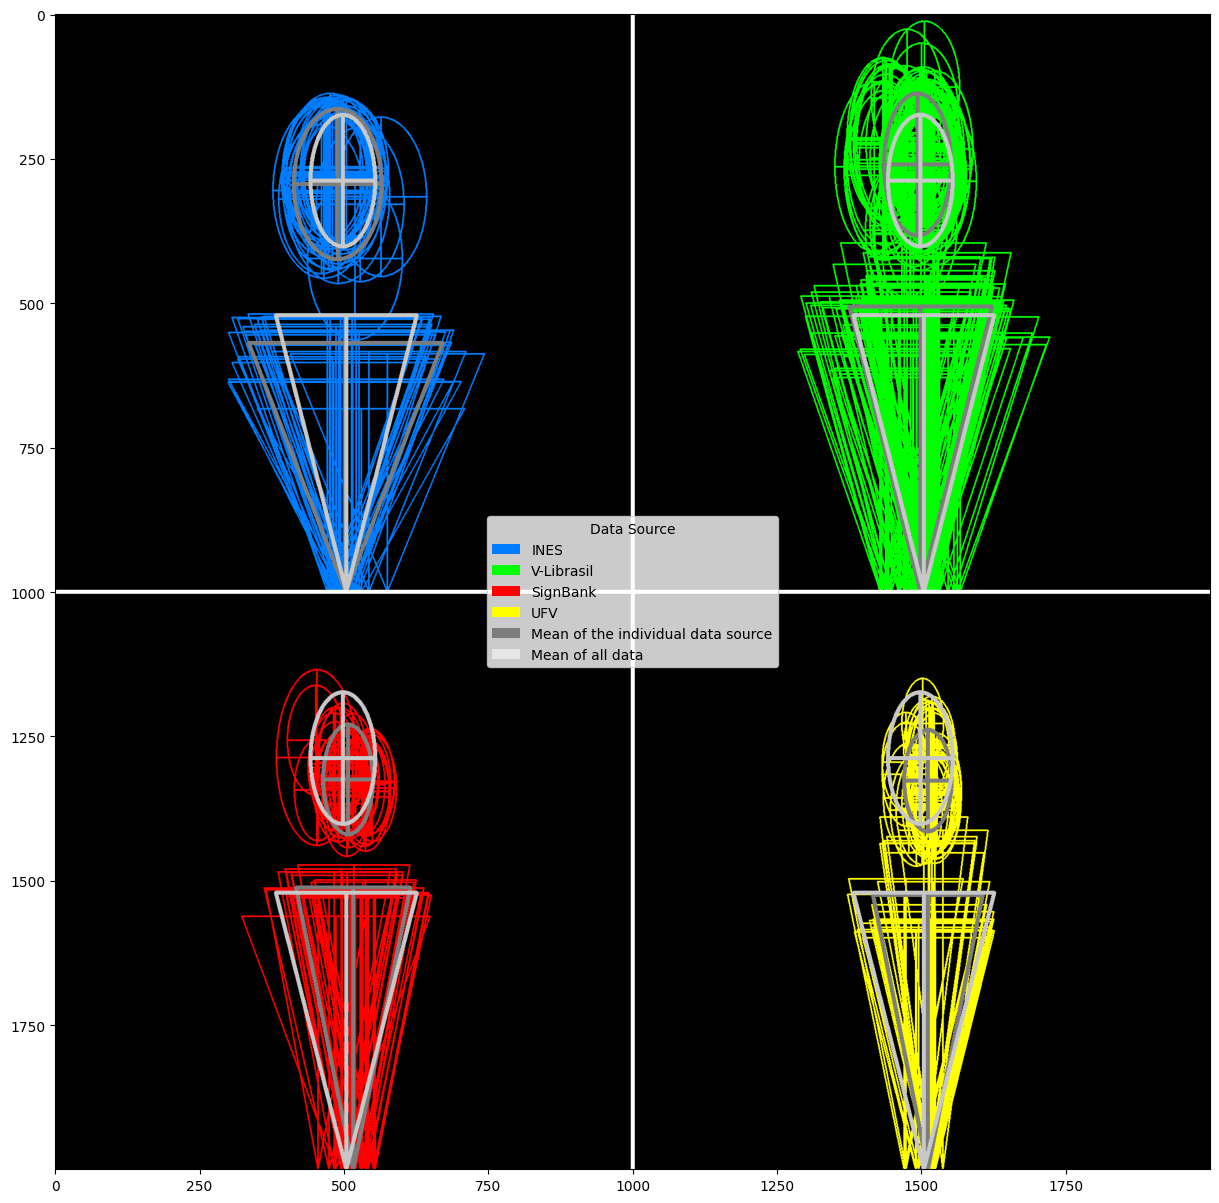

In [14]:
plot_sign_lines = False
canvas_dims = 1000
canvas_ne = np.ones((canvas_dims, canvas_dims, 3), dtype=np.uint8)
canvas_vl = np.ones((canvas_dims, canvas_dims, 3), dtype=np.uint8)
canvas_sb = np.ones((canvas_dims, canvas_dims, 3), dtype=np.uint8)
canvas_uf = np.ones((canvas_dims, canvas_dims, 3), dtype=np.uint8)

for i, row in analysis_info.iterrows():
    data_source = row['metadata_data_source']
    color = color_dict[data_source]
    key_points = {
    'face_horizontal_offset': row['pose_analysis_horizontal_offsets_face_median'],
    'face_vertical_offset': row['pose_analysis_vertical_offsets_face_median'],
    'face_width': row['pose_analysis_landmark_measurements_face_width_median'],
    'face_height': row['pose_analysis_landmark_measurements_face_height_median'],
    'shoulders_horizontal_offset': row['pose_analysis_horizontal_offsets_shoulders_median'],
    'shoulders_vertical_offset': row['pose_analysis_vertical_offsets_shoulders_median'],
    'shoulders_width': row['pose_analysis_landmark_measurements_shoulder_width_median'],
    }
    left_x = int(row['pose_analysis_landmark_measurements_max_left_x_min'] * canvas_dims)
    right_x = int(row['pose_analysis_landmark_measurements_max_right_x_max'] * canvas_dims)
    if data_source == 'ne':
        canvas_ne = viz.plot_key_landmarks(key_points, canvas_ne, color, triangle=True)
        if plot_sign_lines:
            canvas_ne = cv2.rectangle(canvas_ne, (left_x, 0), (right_x, canvas_dims), color, 3)
    if data_source == 'vl':
        canvas_vl = viz.plot_key_landmarks(key_points, canvas_vl, color, triangle=True)
        if plot_sign_lines:
            canvas_vl = cv2.rectangle(canvas_vl, (left_x, 0), (right_x, canvas_dims), color, 3)
    if data_source == 'sb':
        canvas_sb = viz.plot_key_landmarks(key_points, canvas_sb, color, triangle=True)
        if plot_sign_lines:
            canvas_sb = cv2.rectangle(canvas_sb, (left_x, 0), (right_x, canvas_dims), color, 3)
    if data_source == 'uf':
        canvas_uf = viz.plot_key_landmarks(key_points, canvas_uf, color, triangle=True)
        if plot_sign_lines:
            canvas_uf = cv2.rectangle(canvas_uf, (left_x, 0), (right_x, canvas_dims), color, 3)
for canvas_datasource, data_source in zip([canvas_ne, canvas_vl, canvas_sb, canvas_uf], ['ne', 'vl', 'sb', 'uf']):
    viz.plot_key_landmarks(ref_points_by_data_source[data_source], canvas_datasource, (125, 125, 125), triangle=True, line_width=5)
    viz.plot_key_landmarks(mean_ref_points, canvas_datasource, (200, 200, 200), triangle=True, line_width=5)
canvas_top = np.hstack((canvas_ne, canvas_vl))
canvas_bottom = np.hstack((canvas_sb, canvas_uf))
canvas = np.vstack((canvas_top, canvas_bottom))
canvas = cv2.line(canvas, (0, canvas_dims), (canvas.shape[1], canvas_dims), (255, 255, 255), 5)
canvas = cv2.line(canvas, (canvas_dims, 0), (canvas_dims, canvas.shape[0]), (255, 255, 255), 5)

plt.figure(figsize=(15, 15))
plt.imshow(canvas)

legend_patches = [
    plt.Rectangle((0,0), 1, 1, fc=tuple(x/255 for x in color_dict['ne'])),  # blue
    plt.Rectangle((0,0), 1, 1, fc=tuple(x/255 for x in color_dict['vl'])),  # green  
    plt.Rectangle((0,0), 1, 1, fc=tuple(x/255 for x in color_dict['sb'])),  # red
    plt.Rectangle((0,0), 1, 1, fc=tuple(x/255 for x in color_dict['uf'])),  # yellow
    plt.Rectangle((0,0), 1, 1, fc=(125/255, 125/255, 125/255)),  # grey for mean of the individual data source
    plt.Rectangle((0,0), 1, 1, fc=(230/255, 230/255, 230/255))  # white for mean of all data
]
plt.gca().legend(legend_patches, ['INES', 'V-Librasil', 'SignBank', 'UFV', 'Mean of the individual data source', 'Mean of all data'], 
                title='Data Source', loc='center')
plt.show()

In [15]:
key_points_analysis_info.drop(['metadata_filename', 'metadata_data_source'], axis=1).mean()

metadata_frame_count                                          154.826667
metadata_width                                               1352.000000
metadata_height                                               767.333333
pose_analysis_horizontal_offsets_face_median                    0.498270
pose_analysis_vertical_offsets_face_median                      0.288368
pose_analysis_landmark_measurements_face_width_median           0.112783
pose_analysis_landmark_measurements_face_height_median          0.228344
pose_analysis_horizontal_offsets_shoulders_median               0.504666
pose_analysis_vertical_offsets_shoulders_median                 0.521167
pose_analysis_landmark_measurements_shoulder_width_median       0.244432
pose_analysis_landmark_measurements_max_left_x_min              0.259423
pose_analysis_landmark_measurements_max_right_x_max             0.735326
pose_analysis_landmark_measurements_max_top_y_min               0.228667
x_range                                            

In [30]:
key_points_analysis_info['face_mp_to_shoulders'] = key_points_analysis_info['pose_analysis_vertical_offsets_shoulders_median'] - key_points_analysis_info['pose_analysis_vertical_offsets_face_median']

In [33]:
key_points_analysis_info.groupby('metadata_data_source')['pose_analysis_vertical_offsets_face_median'].mean()

metadata_data_source
ne    0.294852
sb    0.325502
uf    0.327891
vl    0.260655
Name: pose_analysis_vertical_offsets_face_median, dtype: float64

In [36]:
key_points_analysis_info.groupby('metadata_data_source')['pose_analysis_vertical_offsets_shoulders_median'].mean()

metadata_data_source
ne    0.569075
sb    0.512282
uf    0.525804
vl    0.506613
Name: pose_analysis_vertical_offsets_shoulders_median, dtype: float64

In [31]:
key_points_analysis_info.groupby('metadata_data_source')['face_mp_to_shoulders'].mean()

metadata_data_source
ne    0.274223
sb    0.186780
uf    0.197913
vl    0.245959
Name: face_mp_to_shoulders, dtype: float64

In [37]:
.52 - .25

0.27

Choosing the Reference Points based on the EDA

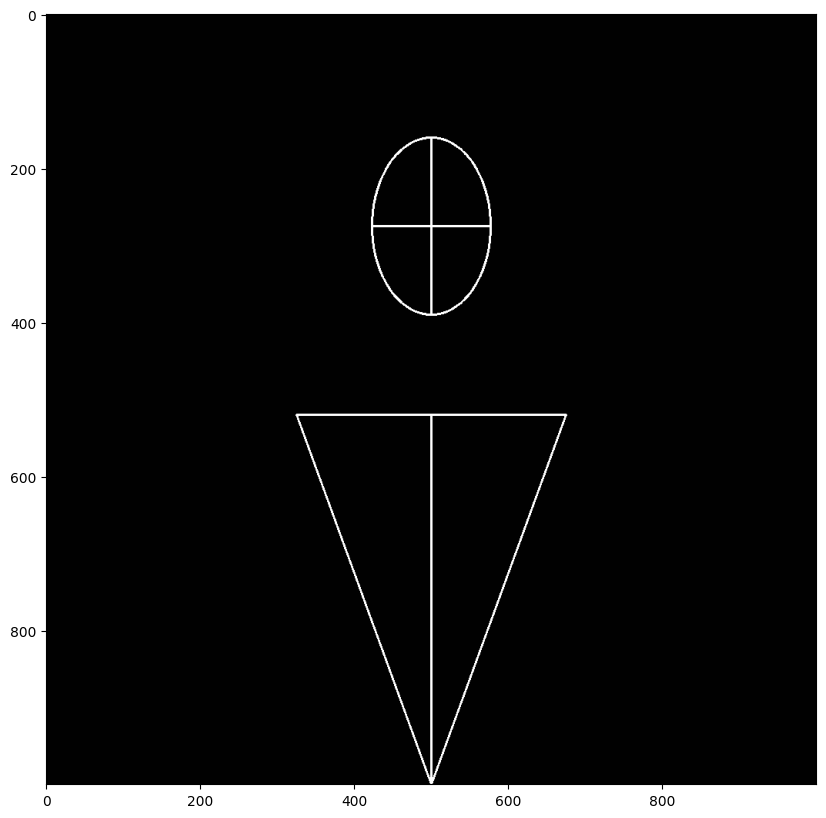

In [17]:
ref_points = {
'face_horizontal_offset': 0.5,
'face_vertical_offset': 0.275,
# 'face_width': 0.11, x1.4
'face_width': 0.154,
'face_height': 0.23,
'shoulders_horizontal_offset': 0.5,
'shoulders_vertical_offset': 0.52,
# 'shoulders_width': 0.25, x1.4
'shoulders_width': 0.35,
}
canvas_dims = 1000
canvas_ref = np.ones((canvas_dims, canvas_dims, 3), dtype=np.uint8)
canvas_ref = viz.plot_key_landmarks(ref_points, canvas_ref, (255, 255, 255), triangle=True)
plt.figure(figsize=(10, 10))
plt.imshow(canvas_ref)

### Horizontal Offset

Text(0.5, 1.0, 'Horizontal Offset of Face - by method')

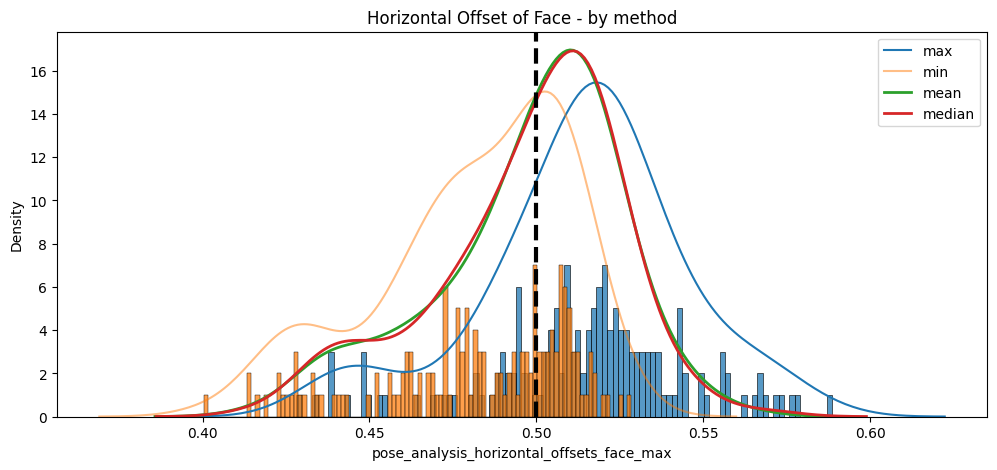

In [ ]:
plt.figure(figsize=(12, 5))
sns.kdeplot(analysis_info.pose_analysis_horizontal_offsets_face_max)
sns.histplot(analysis_info.pose_analysis_horizontal_offsets_face_max, bins=100)

sns.kdeplot(analysis_info.pose_analysis_horizontal_offsets_face_min, alpha = 0.5)
sns.histplot(analysis_info.pose_analysis_horizontal_offsets_face_min, bins=100)

sns.kdeplot(analysis_info.pose_analysis_horizontal_offsets_face_mean, linewidth = 2)
# sns.histplot(analysis_info.pose_analysis_horizontal_offsets_face_mean, bins=100)


sns.kdeplot(analysis_info.pose_analysis_horizontal_offsets_face_median, linewidth = 2)
# sns.histplot(analysis_info.pose_analysis_horizontal_offsets_face_median, bins=100)
#
plt.legend(['max', 'min', 'mean', 'median'])
plt.axvline(0.5, color = 'k', linewidth = 3, linestyle = '--')
plt.title('Horizontal Offset of Face - by method')

Text(0.5, 1.0, 'Horizontal Offset of Shoulders - by method')

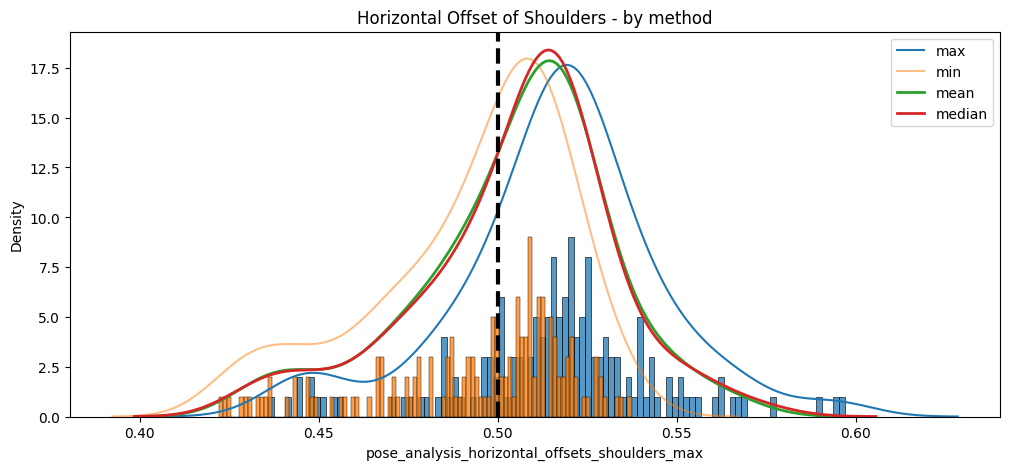

In [ ]:
plt.figure(figsize=(12, 5))
sns.kdeplot(analysis_info.pose_analysis_horizontal_offsets_shoulders_max)
sns.histplot(analysis_info.pose_analysis_horizontal_offsets_shoulders_max, bins=100)

sns.kdeplot(analysis_info.pose_analysis_horizontal_offsets_shoulders_min, alpha = 0.5)
sns.histplot(analysis_info.pose_analysis_horizontal_offsets_shoulders_min, bins=100)

sns.kdeplot(analysis_info.pose_analysis_horizontal_offsets_shoulders_mean, linewidth = 2)
# sns.histplot(analysis_info.pose_analysis_horizontal_offsets_shoulders_mean, bins=100)


sns.kdeplot(analysis_info.pose_analysis_horizontal_offsets_shoulders_median, linewidth = 2)
# sns.histplot(analysis_info.pose_analysis_horizontal_offsets_shoulders_median, bins=100)
#
plt.legend(['max', 'min', 'mean', 'median'])
plt.axvline(0.5, color = 'k', linewidth = 3, linestyle = '--')
plt.title('Horizontal Offset of Shoulders - by method')

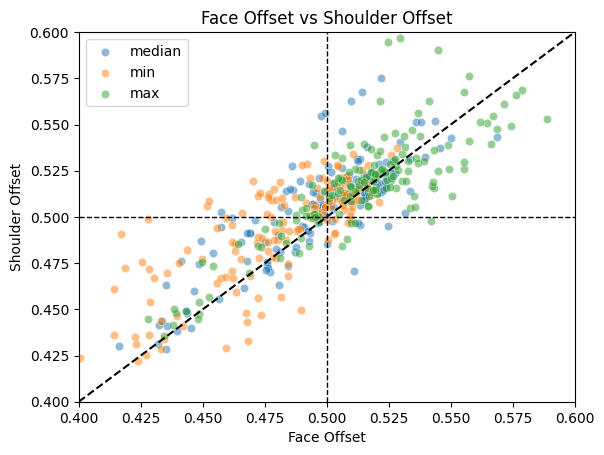

In [ ]:
sns.scatterplot(x = analysis_info.pose_analysis_horizontal_offsets_face_median, y = analysis_info.pose_analysis_horizontal_offsets_shoulders_median, alpha = 0.5)
sns.scatterplot(x = analysis_info.pose_analysis_horizontal_offsets_face_min, y = analysis_info.pose_analysis_horizontal_offsets_shoulders_min, alpha = 0.5)
sns.scatterplot(x = analysis_info.pose_analysis_horizontal_offsets_face_max, y = analysis_info.pose_analysis_horizontal_offsets_shoulders_max, alpha = 0.5)
plt.xlim(0.4, 0.6)
plt.ylim(0.4, 0.6)
plt.plot([0.4, 0.6], [0.4, 0.6], 'k--')
plt.xlabel('Face Offset')
plt.ylabel('Shoulder Offset')
plt.title('Face Offset vs Shoulder Offset')
plt.legend(['median', 'min', 'max'])
plt.axvline(0.5, color = 'k', linewidth = 1, linestyle = '--')
plt.axhline(0.5, color = 'k', linewidth = 1, linestyle = '--')

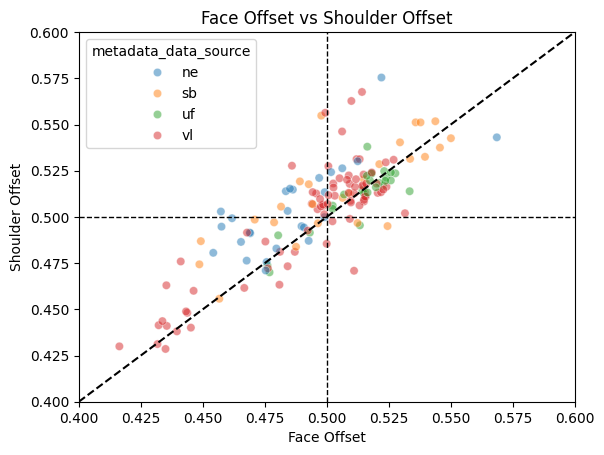

In [ ]:
sns.scatterplot(x = 'pose_analysis_horizontal_offsets_face_median', y = 'pose_analysis_horizontal_offsets_shoulders_median', data = analysis_info, hue = 'metadata_data_source', alpha = 0.5)
plt.xlim(0.4, 0.6)
plt.ylim(0.4, 0.6)
plt.plot([0.4, 0.6], [0.4, 0.6], 'k--')
plt.xlabel('Face Offset')
plt.ylabel('Shoulder Offset')
plt.title('Face Offset vs Shoulder Offset')
plt.axvline(0.5, color = 'k', linewidth = 1, linestyle = '--')
plt.axhline(0.5, color = 'k', linewidth = 1, linestyle = '--')

Text(0.5, 1.0, 'Median Horizontal Offset of Face by Data Source')

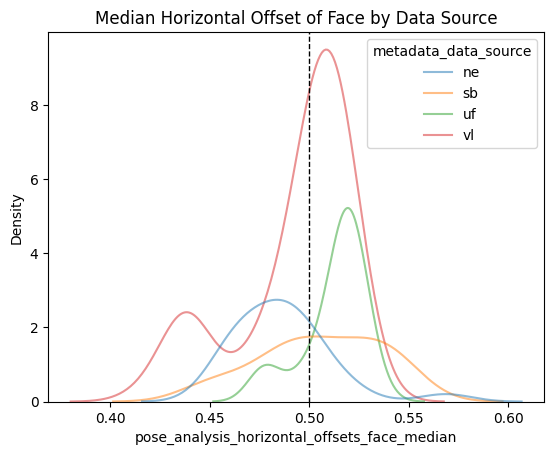

In [ ]:
sns.kdeplot(data = analysis_info, x = 'pose_analysis_horizontal_offsets_face_median', hue = 'metadata_data_source', alpha = 0.5)
plt.axvline(0.5, color = 'k', linewidth = 1, linestyle = '--')
plt.title('Median Horizontal Offset of Face by Data Source')

Text(0.5, 1.0, 'MedianHorizontal Offset of Shoulders by Data Source')

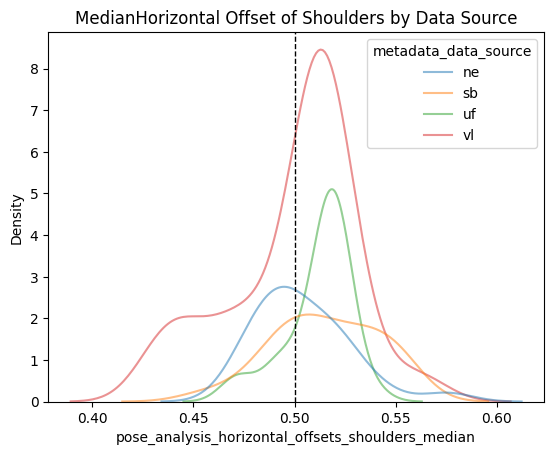

In [ ]:
sns.kdeplot(data = analysis_info, x = 'pose_analysis_horizontal_offsets_shoulders_median', hue = 'metadata_data_source', alpha = 0.5)
plt.axvline(0.5, color = 'k', linewidth = 1, linestyle = '--')
plt.title('MedianHorizontal Offset of Shoulders by Data Source')

### Vertical Offset

Text(0.5, 1.0, 'Vertical Offset of Face - by method')

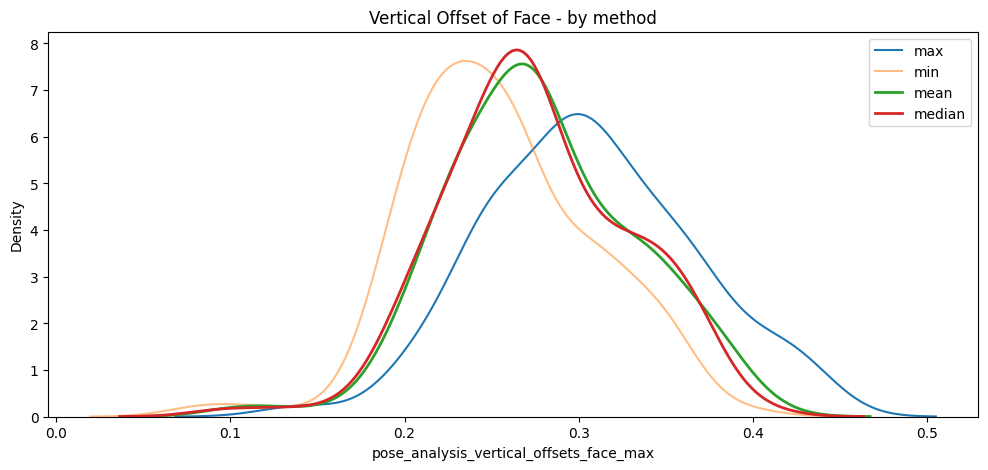

In [ ]:
plt.figure(figsize=(12, 5))
sns.kdeplot(analysis_info.pose_analysis_vertical_offsets_face_max)
# sns.histplot(analysis_info.pose_analysis_vertical_offsets_face_max, bins=100)

sns.kdeplot(analysis_info.pose_analysis_vertical_offsets_face_min, alpha = 0.5)
# sns.histplot(analysis_info.pose_analysis_vertical_offsets_face_min, bins=100)

sns.kdeplot(analysis_info.pose_analysis_vertical_offsets_face_mean, linewidth = 2)
# sns.histplot(analysis_info.pose_analysis_vertical_offsets_face_mean, bins=100)


sns.kdeplot(analysis_info.pose_analysis_vertical_offsets_face_median, linewidth = 2)
# sns.histplot(analysis_info.pose_analysis_vertical_offsets_face_median, bins=100)
#
plt.legend(['max', 'min', 'mean', 'median'])
# plt.axvline(0.5, color = 'k', linewidth = 3, linestyle = '--')
plt.title('Vertical Offset of Face - by method')

Text(0.5, 1.0, 'Vertical Offset of Shoulders - by method')

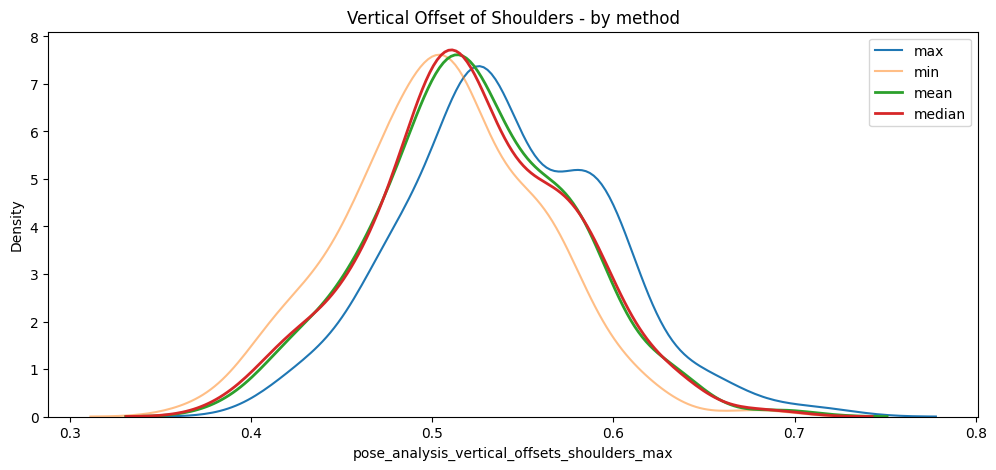

In [ ]:
plt.figure(figsize=(12, 5))
sns.kdeplot(analysis_info.pose_analysis_vertical_offsets_shoulders_max)
# sns.histplot(analysis_info.pose_analysis_vertical_offsets_shoulders_max, bins=100)

sns.kdeplot(analysis_info.pose_analysis_vertical_offsets_shoulders_min, alpha = 0.5)
# sns.histplot(analysis_info.pose_analysis_vertical_offsets_shoulders_min, bins=100)

sns.kdeplot(analysis_info.pose_analysis_vertical_offsets_shoulders_mean, linewidth = 2)
# sns.histplot(analysis_info.pose_analysis_vertical_offsets_shoulders_mean, bins=100)


sns.kdeplot(analysis_info.pose_analysis_vertical_offsets_shoulders_median, linewidth = 2)
# sns.histplot(analysis_info.pose_analysis_vertical_offsets_shoulders_median, bins=100)
#
plt.legend(['max', 'min', 'mean', 'median'])
plt.title('Vertical Offset of Shoulders - by method')

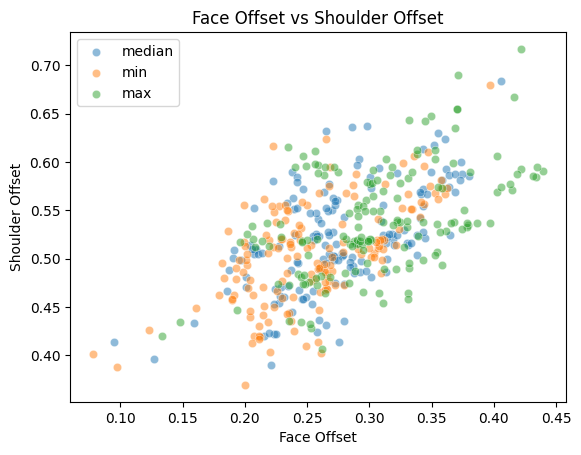

In [ ]:
sns.scatterplot(x = analysis_info.pose_analysis_vertical_offsets_face_median, y = analysis_info.pose_analysis_vertical_offsets_shoulders_median, alpha = 0.5)
sns.scatterplot(x = analysis_info.pose_analysis_vertical_offsets_face_min, y = analysis_info.pose_analysis_vertical_offsets_shoulders_min, alpha = 0.5)
sns.scatterplot(x = analysis_info.pose_analysis_vertical_offsets_face_max, y = analysis_info.pose_analysis_vertical_offsets_shoulders_max, alpha = 0.5)

plt.xlabel('Face Offset')
plt.ylabel('Shoulder Offset')
plt.title('Face Offset vs Shoulder Offset')
plt.legend(['median', 'min', 'max'])

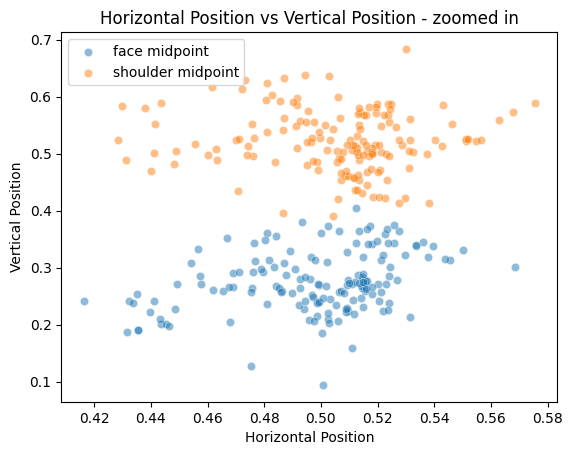

In [ ]:
sns.scatterplot(x = analysis_info.pose_analysis_horizontal_offsets_face_median, y = analysis_info.pose_analysis_vertical_offsets_face_median, alpha = 0.5)
sns.scatterplot(x = analysis_info.pose_analysis_horizontal_offsets_shoulders_median, y = analysis_info.pose_analysis_vertical_offsets_shoulders_median, alpha = 0.5)

plt.xlabel('Horizontal Position')
plt.ylabel('Vertical Position')
plt.title('Horizontal Position vs Vertical Position - zoomed in')
plt.legend(['face midpoint', 'shoulder midpoint'])

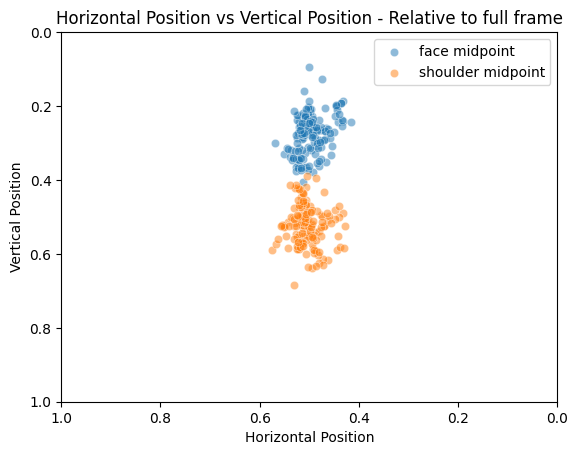

In [ ]:
sns.scatterplot(x = analysis_info.pose_analysis_horizontal_offsets_face_median, y = analysis_info.pose_analysis_vertical_offsets_face_median, alpha = 0.5)
sns.scatterplot(x = analysis_info.pose_analysis_horizontal_offsets_shoulders_median, y = analysis_info.pose_analysis_vertical_offsets_shoulders_median, alpha = 0.5)
plt.xlim(1, 0)
plt.ylim(1, 0)
plt.xlabel('Horizontal Position')
plt.ylabel('Vertical Position')
plt.title('Horizontal Position vs Vertical Position - Relative to full frame')
plt.legend(['face midpoint', 'shoulder midpoint'])

In [22]:
color_dict

{'ne': (0, 125, 255),
 'vl': (0, 255, 0),
 'sb': (255, 0, 0),
 'uf': (255, 255, 0)}

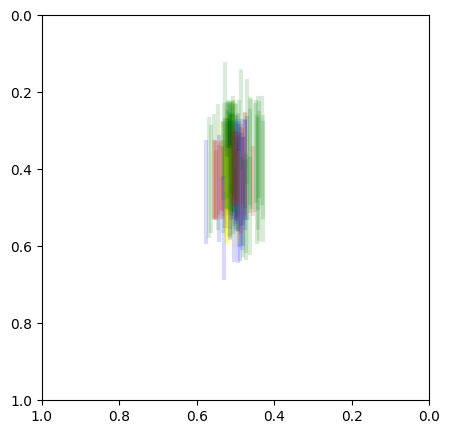

In [28]:
plt.figure(figsize=(5, 5))
plt.xlim(1, 0)
plt.ylim(1, 0)
for i, row in analysis_info.iterrows():
    x = row['pose_analysis_horizontal_offsets_shoulders_median']
    ymin = row['pose_analysis_vertical_offsets_shoulders_median']
    ymax = row['pose_analysis_vertical_offsets_face_median']
    data_source = row['metadata_data_source']
    col = {'ne': 'blue',
            'vl': 'green',
            'sb': 'red',
            'uf': 'yellow'}[data_source]
    plt.plot([x, x], [ymin, ymax], color = col, linewidth = 3, alpha = 0.15)

Text(0.5, 1.0, 'Horizontal Position vs Vertical Position\n-Face and Shoulder Midpoints\n-by data source\n-relative to full frame')

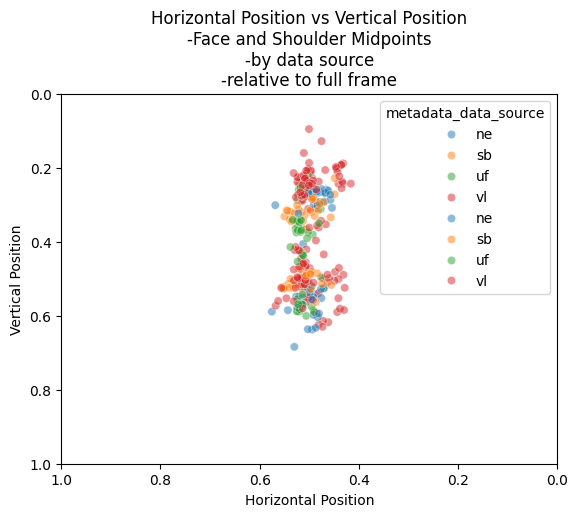

In [ ]:
sns.scatterplot(data = analysis_info, x = 'pose_analysis_horizontal_offsets_face_median', y = 'pose_analysis_vertical_offsets_face_median', alpha = 0.5, hue = 'metadata_data_source')
sns.scatterplot(data = analysis_info, x = 'pose_analysis_horizontal_offsets_shoulders_median', y = 'pose_analysis_vertical_offsets_shoulders_median', alpha = 0.5, hue = 'metadata_data_source')
plt.xlim(1, 0)
plt.ylim(1, 0)
plt.xlabel('Horizontal Position')
plt.ylabel('Vertical Position')
plt.title('Horizontal Position vs Vertical Position\n-Face and Shoulder Midpoints\n-by data source\n-relative to full frame')